# 1. Default Models

## 1.1 LR

In [ ]:
import matplotlib.pyplot as plt
import time

In [ ]:
# =========================================================
# 0) Setup (Colab installs) + Utilities
# =========================================================

import os, math, random, glob
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import average_precision_score, precision_recall_curve

# Silence pipeline init logs unless overridden upstream
os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")
import mNDWS_models as mndws_models

mndws_models.set_seed(1337)
device = mndws_models.device
use_cuda = mndws_models.use_cuda
use_mps = mndws_models.use_mps
print("Device:", device)

No NPZ tiles found — converting from mNDWS TFRecords...


100%|██████████| 4.15G/4.15G [00:29<00:00, 151MB/s]

Extracting files...


Kaggle dataset path: /root/.cache/kagglehub/datasets/georgehulsey/modified-next-day-wildfire-spread/versions/1


Converting TFRecords → NPZ (mNDWS): 100%|██████████| 54/54 [03:49<00:00,  4.25s/it]


Converted 20097 tiles → /scratch/root/wildfire_npz_tiles_mndws_v1
Skipped (no masks): 0
Device: cuda
Reusing NPZ tiles from pipeline at: /scratch/root/wildfire_npz_tiles_mndws_v1
Device: cuda


In [ ]:
# --- Reuse shared pipeline hookup from mNDWS_models ---
# configure_channels() honors the global USE_CHANNELS definition and supports ablations.
CHANNELS_FOR_MODEL = mndws_models.configure_channels()
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = mndws_models.pipeline_hookup(
    CHANNELS_FOR_MODEL=CHANNELS_FOR_MODEL,
    BATCH_SIZE=16,
 )

def build_lr_input(X_raw0, mean=None, std=None):
    mean_t = mean if mean is not None else meanC
    std_t = std if std is not None else stdC
    return mndws_models.build_lr_input(X_raw0, mean_t, std_t)

print(f'Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}')

Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([21]) torch.Size([21])
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']


In [ ]:
# =========================================================
# 4) Pixel Logistic Regression (1x1 conv) — uses shared module definition
# =========================================================
lr_model, pw, criterion, optimizer = mndws_models.PixelLogReg_outputs(
    train_ds=train_ds,
    meanC=meanC,
    stdC=stdC,
    train_loader=train_loader,
    device=device,
 )

# Change number of epochs for training here
EPOCHS_LR = 50

in_ch = 21 pos_weight = 32.9764289855957


In [ ]:
# =========================================================
# 5) Train / Eval loops, change number of epochs above
# =========================================================


def train_lr_epoch():
    lr_model.train()
    losses = []
    tiles_seen = 0
    for b in tqdm(train_loader, desc="train LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        logits = lr_model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        tiles_seen += X_raw0.size(0)
    return float(np.mean(losses)), tiles_seen

@torch.no_grad()
def eval_lr(loader, *, model=None, desc=None):
    model = lr_model if model is None else model
    model.eval()
    all_p, all_t = [], []
    iter_desc = desc if desc is not None else "eval LR"
    for b in tqdm(loader, desc=iter_desc, leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    if t.sum() == 0:
        return 0.0, 0.0, 0.5, 0.0
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    yhat = (p >= best_thr).astype(np.float32)
    intersection = float((yhat * t).sum())
    union = float(yhat.sum() + t.sum() - intersection)
    iou = intersection / (union + 1e-8)
    return float(ap), float(f1.max()), float(best_thr), float(iou)

# Shared artifact path so we can skip retraining when cached weights exist
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_thr_val = 0.5
cached_artifact = False
artifact = {}

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in lr_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)

if os.path.exists(ART_PATH):
    print(f"Loading cached PixelLogReg artifact from {ART_PATH}")
    artifact = torch.load(ART_PATH, map_location=device)
    saved_channels = artifact.get("channels")
    current_channels = list(train_ds.channels)
    if saved_channels == current_channels:
        lr_model.load_state_dict(artifact["state_dict"])
        best_thr_val = float(artifact.get("best_thr", 0.5))
        train_loss_hist = list(artifact.get("train_loss_hist", []))
        val_ap_hist = list(artifact.get("val_ap_hist", []))
        val_f1_hist = list(artifact.get("val_f1_hist", []))
        val_thr_hist = list(artifact.get("val_thr_hist", []))
        val_iou_hist = list(artifact.get("val_iou_hist", []))
        compute_metrics.update(artifact.get("compute_metrics", {}))
        cached_artifact = True
    else:
        print("Cached artifact channel order differs from requested dataset; retraining.")
else:
    print("No cached PixelLogReg artifact found; training from scratch.")

if not cached_artifact:
    best_val_ap_lr = -1.0
    best_state = None

    for e in range(EPOCHS_LR):
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_start = time.perf_counter()
        tr_loss, tiles_seen = train_lr_epoch()
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_duration = time.perf_counter() - epoch_start
        epoch_times.append(epoch_duration)
        epoch_tiles.append(tiles_seen)
        ap, f1, thr, iou = eval_lr(val_loader)
        train_loss_hist.append(tr_loss)
        val_ap_hist.append(ap)
        val_f1_hist.append(f1)
        val_thr_hist.append(thr)
        val_iou_hist.append(iou)
        print(f"[LR] Epoch {e:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
        if ap > best_val_ap_lr:
            best_val_ap_lr = ap
            best_state = {k: v.cpu().clone() for k, v in lr_model.state_dict().items()}

    if best_state is not None:
        lr_model.load_state_dict(best_state)

    _, _, best_thr_val, best_iou_val = eval_lr(val_loader)
    if val_thr_hist:
        val_thr_hist[-1] = best_thr_val
    else:
        val_thr_hist.append(best_thr_val)
    if val_iou_hist:
        val_iou_hist[-1] = best_iou_val
    else:
        val_iou_hist.append(best_iou_val)

    if epoch_times:
        avg_epoch = float(np.mean(epoch_times))
        std_epoch = float(np.std(epoch_times))
        total_time = float(np.sum(epoch_times))
        total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
        throughput = float(total_tiles / total_time) if total_time > 0 else None
    else:
        avg_epoch = std_epoch = throughput = None
    if use_cuda:
        torch.cuda.synchronize(device)
        peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
    elif use_mps:
        torch.mps.synchronize()
    latency_s = None
else:
    if not val_thr_hist:
        val_ap, val_f1, best_thr_val, best_iou_val = eval_lr(val_loader)
        val_ap_hist = [val_ap]
        val_f1_hist = [val_f1]
        val_thr_hist = [best_thr_val]
        val_iou_hist = [best_iou_val]
        print("Cached artifact missing history; recomputed validation metrics.")
    else:
        best_thr_val = float(artifact.get("best_thr", val_thr_hist[-1]))
        if not val_iou_hist:
            _, _, _, best_iou_val = eval_lr(val_loader)
            val_iou_hist = [best_iou_val]
    avg_epoch = compute_metrics.get("avg_epoch", None)
    std_epoch = compute_metrics.get("std_epoch", None)
    throughput = compute_metrics.get("throughput_tiles_per_s", None)
    peak_gpu_gb = compute_metrics.get("peak_gpu_gb", None)
    latency_s = compute_metrics.get("latency_s", None)

@torch.no_grad()
def test_at_thr(thr):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(test_loader, desc="test LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    ap = average_precision_score(t, p)
    yhat = (p >= thr).astype(np.float32)
    tp = (yhat * t).sum()
    fp = (yhat * (1 - t)).sum()
    fn = ((1 - yhat) * t).sum()
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    union = yhat.sum() + t.sum() - tp
    iou = tp / (union + 1e-8)
    print(f"[LR] TEST @thr={thr:.3f} | AP={ap:.4f} | P={prec:.3f} R={rec:.3f} F1={f1:.3f} IoU={iou:.3f}")
    return float(ap), float(f1), float(iou)


test_ap_lr, test_f1_lr, test_iou_lr = test_at_thr(best_thr_val)

@torch.no_grad()
def measure_latency(ds, repeats=50):
    if len(ds) == 0:
        return None
    lr_model.eval()
    sample = ds[0]["X_raw"].unsqueeze(0).to(device)
    X = build_lr_input(sample)
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    start = time.perf_counter()
    for _ in range(repeats):
        torch.sigmoid(lr_model(X))
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    return (time.perf_counter() - start) / repeats

if latency_s is None:
    latency_s = measure_latency(test_ds, repeats=100)
if use_cuda and peak_gpu_gb is None:
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

No cached PixelLogReg artifact found; training from scratch.


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 00 | loss 1.3243 | VAL AP 0.0500 | VAL F1* 0.1029 | VAL IoU 0.0542 | thr≈0.644


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 01 | loss 1.2545 | VAL AP 0.0651 | VAL F1* 0.1299 | VAL IoU 0.0695 | thr≈0.669


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 02 | loss 1.2413 | VAL AP 0.0780 | VAL F1* 0.1533 | VAL IoU 0.0830 | thr≈0.675


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 03 | loss 1.2148 | VAL AP 0.0883 | VAL F1* 0.1725 | VAL IoU 0.0944 | thr≈0.686


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 04 | loss 1.1952 | VAL AP 0.0966 | VAL F1* 0.1837 | VAL IoU 0.1011 | thr≈0.696


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 05 | loss 1.1528 | VAL AP 0.1102 | VAL F1* 0.2030 | VAL IoU 0.1130 | thr≈0.698


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 06 | loss 1.1357 | VAL AP 0.1199 | VAL F1* 0.2160 | VAL IoU 0.1210 | thr≈0.698


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 07 | loss 1.1683 | VAL AP 0.1312 | VAL F1* 0.2333 | VAL IoU 0.1320 | thr≈0.696


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 08 | loss 1.1030 | VAL AP 0.1421 | VAL F1* 0.2496 | VAL IoU 0.1426 | thr≈0.703


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 09 | loss 1.0942 | VAL AP 0.1550 | VAL F1* 0.2647 | VAL IoU 0.1525 | thr≈0.707


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 10 | loss 1.1040 | VAL AP 0.1687 | VAL F1* 0.2822 | VAL IoU 0.1643 | thr≈0.711


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 11 | loss 1.1200 | VAL AP 0.1792 | VAL F1* 0.2928 | VAL IoU 0.1715 | thr≈0.712


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 12 | loss 1.0805 | VAL AP 0.1850 | VAL F1* 0.3014 | VAL IoU 0.1774 | thr≈0.724


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 13 | loss 1.1053 | VAL AP 0.1957 | VAL F1* 0.3166 | VAL IoU 0.1880 | thr≈0.717


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 14 | loss 1.0553 | VAL AP 0.2072 | VAL F1* 0.3316 | VAL IoU 0.1987 | thr≈0.716


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 15 | loss 1.0535 | VAL AP 0.2122 | VAL F1* 0.3372 | VAL IoU 0.2028 | thr≈0.727


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 16 | loss 1.0298 | VAL AP 0.2165 | VAL F1* 0.3427 | VAL IoU 0.2068 | thr≈0.720


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 17 | loss 1.0576 | VAL AP 0.2176 | VAL F1* 0.3460 | VAL IoU 0.2092 | thr≈0.728


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 18 | loss 1.0749 | VAL AP 0.2234 | VAL F1* 0.3538 | VAL IoU 0.2149 | thr≈0.731


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 19 | loss 1.0520 | VAL AP 0.2298 | VAL F1* 0.3638 | VAL IoU 0.2223 | thr≈0.721


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 20 | loss 1.0556 | VAL AP 0.2317 | VAL F1* 0.3674 | VAL IoU 0.2250 | thr≈0.728


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 21 | loss 1.0269 | VAL AP 0.2315 | VAL F1* 0.3706 | VAL IoU 0.2275 | thr≈0.734


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 22 | loss 1.0433 | VAL AP 0.2344 | VAL F1* 0.3736 | VAL IoU 0.2297 | thr≈0.737


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 23 | loss 1.0383 | VAL AP 0.2371 | VAL F1* 0.3787 | VAL IoU 0.2335 | thr≈0.740


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 24 | loss 1.0134 | VAL AP 0.2415 | VAL F1* 0.3876 | VAL IoU 0.2403 | thr≈0.728


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 25 | loss 0.9891 | VAL AP 0.2454 | VAL F1* 0.3921 | VAL IoU 0.2439 | thr≈0.738


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 26 | loss 1.0157 | VAL AP 0.2471 | VAL F1* 0.3946 | VAL IoU 0.2458 | thr≈0.741


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 27 | loss 1.0201 | VAL AP 0.2446 | VAL F1* 0.3938 | VAL IoU 0.2452 | thr≈0.751


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 28 | loss 0.9873 | VAL AP 0.2477 | VAL F1* 0.3995 | VAL IoU 0.2496 | thr≈0.744


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 29 | loss 1.0186 | VAL AP 0.2513 | VAL F1* 0.4083 | VAL IoU 0.2565 | thr≈0.751


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 30 | loss 0.9818 | VAL AP 0.2504 | VAL F1* 0.4111 | VAL IoU 0.2587 | thr≈0.756


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 31 | loss 0.9660 | VAL AP 0.2506 | VAL F1* 0.4127 | VAL IoU 0.2600 | thr≈0.766


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 32 | loss 0.9760 | VAL AP 0.2513 | VAL F1* 0.4179 | VAL IoU 0.2642 | thr≈0.760


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 33 | loss 0.9591 | VAL AP 0.2514 | VAL F1* 0.4192 | VAL IoU 0.2651 | thr≈0.756


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 34 | loss 0.9980 | VAL AP 0.2502 | VAL F1* 0.4170 | VAL IoU 0.2634 | thr≈0.771


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 35 | loss 1.0058 | VAL AP 0.2483 | VAL F1* 0.4130 | VAL IoU 0.2603 | thr≈0.780


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 36 | loss 0.9460 | VAL AP 0.2514 | VAL F1* 0.4189 | VAL IoU 0.2649 | thr≈0.780


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 37 | loss 0.9788 | VAL AP 0.2524 | VAL F1* 0.4205 | VAL IoU 0.2662 | thr≈0.786


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 38 | loss 0.9985 | VAL AP 0.2518 | VAL F1* 0.4187 | VAL IoU 0.2648 | thr≈0.792


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 39 | loss 0.9767 | VAL AP 0.2511 | VAL F1* 0.4206 | VAL IoU 0.2663 | thr≈0.792


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 40 | loss 0.9795 | VAL AP 0.2511 | VAL F1* 0.4210 | VAL IoU 0.2667 | thr≈0.802


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 41 | loss 0.9696 | VAL AP 0.2511 | VAL F1* 0.4220 | VAL IoU 0.2675 | thr≈0.800


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 42 | loss 0.9190 | VAL AP 0.2534 | VAL F1* 0.4251 | VAL IoU 0.2699 | thr≈0.803


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 43 | loss 0.9891 | VAL AP 0.2535 | VAL F1* 0.4274 | VAL IoU 0.2717 | thr≈0.773


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 44 | loss 0.9813 | VAL AP 0.2537 | VAL F1* 0.4272 | VAL IoU 0.2716 | thr≈0.778


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 45 | loss 0.9531 | VAL AP 0.2544 | VAL F1* 0.4295 | VAL IoU 0.2735 | thr≈0.781


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 46 | loss 0.9832 | VAL AP 0.2510 | VAL F1* 0.4251 | VAL IoU 0.2699 | thr≈0.819


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 47 | loss 0.9932 | VAL AP 0.2516 | VAL F1* 0.4260 | VAL IoU 0.2707 | thr≈0.806


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 48 | loss 0.9778 | VAL AP 0.2535 | VAL F1* 0.4298 | VAL IoU 0.2737 | thr≈0.801


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 49 | loss 0.9954 | VAL AP 0.2527 | VAL F1* 0.4301 | VAL IoU 0.2740 | thr≈0.802


eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

test LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] TEST @thr=0.781 | AP=0.2340 | P=0.381 R=0.450 F1=0.413 IoU=0.260


In [ ]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[LR] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[LR] Computation metrics summary:
  Learnable parameters         22
  Avg. epoch wall time         1.712 s
  Epoch time stdev             0.202 s
  Training throughput          700.989 tiles/s
  Peak GPU memory              0.022 GB
  Inference latency (1 tile)   0.139 ms


In [ ]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([21, 64, 64])
Height x Width: 64 x 64


In [ ]:
# =========================================================
# 7) Save artifacts (channel-aware, non-/content path)
# =========================================================
import os
import torch

ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

artifact = {
    "state_dict": {k: v.cpu() for k, v in lr_model.state_dict().items()},
    "model": {"type": "PixelLogReg", "in_ch": len(train_ds.channels)},
    "channels": list(train_ds.channels),
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "pos_weight": float(pw),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_iou_hist": list(val_iou_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /root/wildfire_artifacts/lr/pixel_logreg.pt


In [ ]:
test_ap_lr, test_f1_lr, test_iou_lr

(0.23401248842102462, 0.41297805309295654, 0.2602219879627228)

In [ ]:
# =========================================================
# Final validation/test metrics (LR baseline)
# =========================================================
variants = {"Raw": lr_model}

final_metrics = {}
for name, model_obj in variants.items():
    ap_val, f1_val, thr_val, iou_val = eval_lr(val_loader, model=model_obj, desc=f"VAL {name}")
    ap_test, f1_test, thr_test, iou_test = eval_lr(test_loader, model=model_obj, desc=f"TEST {name}")
    final_metrics[name] = {
        "val_ap": ap_val,
        "val_f1": f1_val,
        "val_iou": iou_val,
        "val_thr": thr_val,
        "test_ap": ap_test,
        "test_f1": f1_test,
        "test_iou": iou_test,
        "test_thr": thr_test,
    }

print("Final metrics (val/test):")
for name, stats in final_metrics.items():
    print(
        f"  {name:6s} | VAL AP {stats['val_ap']:.4f} F1 {stats['val_f1']:.4f} IoU {stats['val_iou']:.4f} thr≈{stats['val_thr']:.3f}"
        f" | TEST AP {stats['test_ap']:.4f} F1 {stats['test_f1']:.4f} IoU {stats['test_iou']:.4f}",
    )

VAL Raw:   0%|          | 0/19 [00:00<?, ?it/s]

TEST Raw:   0%|          | 0/19 [00:00<?, ?it/s]

Final metrics (val/test):
  Raw    | VAL AP 0.2544 F1 0.4295 IoU 0.2735 thr≈0.781 | TEST AP 0.2340 F1 0.4131 IoU 0.2604


## 1.2 UNet

In [ ]:
# =========================================================
# PhysicsPrior notebook bootstrap via module import
# =========================================================
import importlib.util
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import torch
import torch.nn as nn
from contextlib import nullcontext
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix
from tqdm import tqdm

repo_root = pathlib.Path.cwd()
module_path = repo_root / "mNDWS_models.py"
print(f"Loading shared models module from: {module_path}")
spec = importlib.util.spec_from_file_location("mndws_models_copy", module_path)
models = importlib.util.module_from_spec(spec)
spec.loader.exec_module(models)
sys.modules["mndws_models_copy"] = models

set_seed = models.set_seed
set_seed(1337)

device = models.device
use_cuda = models.use_cuda
use_mps = models.use_mps
print("Device:", device)

Loading shared models module from: /content/mNDWS_models.py
Device: cuda
Reusing NPZ tiles from pipeline at: /scratch/root/wildfire_npz_tiles_mndws_v1
Device: cuda


In [ ]:
# --- Reuse pipeline + loader configuration from shared module ---
BATCH_SIZE = 16
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = models.pipeline_hookup(
    BATCH_SIZE=BATCH_SIZE
)
CHANNELS_FOR_MODEL = list(train_ds.channels)
print(f"Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}")

Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([21]) torch.Size([21])
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']


In [ ]:
# =========================================================
# PhysicsPrior UNet bundle + optimizer/criterion setup
# =========================================================
pos_weight = models.pos_weight_from_loader(train_loader)

bundle = models.build_physics_unet_bundle(
    CHANNELS_FOR_MODEL,
    meanC,
    stdC,
    base_width=80,
    ema_decay=0.999,
    loss_type="hybrid",  # combines focal + Tversky
    loss_kwargs={
        "pos_weight": pos_weight,
        "focal_alpha": 0.25,
        "focal_gamma": 2.0,
        "focal_weight": 0.5,  # 0→pure Tversky, 1→pure focal
        "tversky_alpha": 0.7,
        "tversky_beta": 0.3,
    },
)
physics_model = bundle["model"]
feature_builder = bundle["feature_builder"]
ema_tracker = bundle["ema"]
polyak_tracker = bundle["polyak"]
criterion = bundle["criterion"]

optimizer = torch.optim.AdamW(physics_model.parameters(), lr=2e-4, weight_decay=1e-4)
amp_enabled = use_cuda
scaler = torch.amp.GradScaler(device="cuda", enabled=amp_enabled)
if amp_enabled:
    def autocast_ctx():
        return torch.amp.autocast(device_type="cuda")
else:
    autocast_ctx = nullcontext
amp_stream = autocast_ctx

print(f"pos_weight = {float(pos_weight):.3f}")
print(
    f"Model parameters: {sum(p.numel() for p in physics_model.parameters() if p.requires_grad)/1e6:.2f} M"
)
print(f"Loss config: {bundle['loss_config']}")

PhysicsPrior UNet init -> in:16 base:80 | parameters: 12.04 M
pos_weight = 32.897
Model parameters: 12.04 M
Loss config: {'type': 'hybrid', 'kwargs': {'pos_weight': tensor(32.8968, device='cuda:0'), 'focal_alpha': 0.25, 'focal_gamma': 2.0, 'focal_weight': 0.5, 'tversky_alpha': 0.7, 'tversky_beta': 0.3}}


In [ ]:
# =========================================================
# Train / Eval loops for PhysicsPrior UNet
# =========================================================
EPOCHS_PHYSICS = 50
amp_stream = autocast_ctx

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_val_ap = -1.0
best_state = None

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in physics_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)


def _forward_batch(model_obj, batch):
    X_raw = batch["X_raw"].to(device, non_blocking=True)
    y = batch["y"].to(device, non_blocking=True)
    feats = feature_builder(X_raw)
    return feats, y


def train_physics_epoch():
    physics_model.train()
    losses = []
    tiles_seen = 0
    for batch in tqdm(train_loader, desc="train Physics", leave=False):
        feats, y = _forward_batch(physics_model, batch)
        optimizer.zero_grad(set_to_none=True)
        with amp_stream():
            logits = physics_model(feats)
            loss = criterion(logits, y)
        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        ema_tracker.update(physics_model)
        polyak_tracker.update(physics_model)
        losses.append(loss.item())
        tiles_seen += feats.size(0)
    return float(np.mean(losses)), tiles_seen


@torch.no_grad()
def eval_physics(model_obj, loader, desc="eval Physics"):
    model_obj.eval()
    all_p, all_t = [], []
    for batch in tqdm(loader, desc=desc, leave=False):
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        p = torch.sigmoid(logits).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    if t.sum() == 0:
        return 0.0, 0.0, 0.5, 0.0
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    yhat = (p >= best_thr).astype(np.float32)
    intersection = float((yhat * t).sum())
    union = float(yhat.sum() + t.sum() - intersection)
    iou = intersection / (union + 1e-8)
    return float(ap), float(f1.max()), float(best_thr), float(iou)


best_thr_val = 0.5

for epoch in range(EPOCHS_PHYSICS):
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_start = time.perf_counter()
    tr_loss, tiles_seen = train_physics_epoch()
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_duration = time.perf_counter() - epoch_start
    epoch_times.append(epoch_duration)
    epoch_tiles.append(tiles_seen)
    ap, f1, thr, iou = eval_physics(physics_model, val_loader)
    train_loss_hist.append(tr_loss)
    val_ap_hist.append(ap)
    val_f1_hist.append(f1)
    val_thr_hist.append(thr)
    val_iou_hist.append(iou)
    print(f"[Physics] Epoch {epoch:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
    if ap > best_val_ap:
        best_val_ap = ap
        best_state = {k: v.cpu().clone() for k, v in physics_model.state_dict().items()}

if best_state is not None:
    physics_model.load_state_dict(best_state)

best_thr_val = val_thr_hist[-1] if val_thr_hist else 0.5

if epoch_times:
    avg_epoch = float(np.mean(epoch_times))
    std_epoch = float(np.std(epoch_times))
    total_time = float(np.sum(epoch_times))
    total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
    throughput = float(total_tiles / total_time) if total_time > 0 else None
else:
    avg_epoch = std_epoch = throughput = None

if use_cuda:
    torch.cuda.synchronize(device)
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
elif use_mps:
    torch.mps.synchronize()

@torch.no_grad()
def measure_latency(ds, model_obj, repeats=50):
    if len(ds) == 0:
        return None
    model_obj.eval()
    sample = ds[0]["X_raw"].unsqueeze(0).to(device)
    feats = feature_builder(sample)
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    start = time.perf_counter()
    for _ in range(repeats):
        torch.sigmoid(model_obj(feats))
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    return (time.perf_counter() - start) / repeats

latency_s = measure_latency(test_ds, physics_model, repeats=100)

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

[Physics] Epoch 00 | loss 0.5304 | VAL AP 0.3231 | VAL F1* 0.4415 | VAL IoU 0.2833 | thr≈0.678


[Physics] Epoch 01 | loss 0.5089 | VAL AP 0.3655 | VAL F1* 0.4542 | VAL IoU 0.2938 | thr≈0.659


[Physics] Epoch 02 | loss 0.5019 | VAL AP 0.3626 | VAL F1* 0.4611 | VAL IoU 0.2996 | thr≈0.701


[Physics] Epoch 03 | loss 0.4979 | VAL AP 0.4192 | VAL F1* 0.4816 | VAL IoU 0.3172 | thr≈0.690


[Physics] Epoch 04 | loss 0.4916 | VAL AP 0.3934 | VAL F1* 0.4753 | VAL IoU 0.3117 | thr≈0.662


[Physics] Epoch 05 | loss 0.4886 | VAL AP 0.4227 | VAL F1* 0.4782 | VAL IoU 0.3143 | thr≈0.710


[Physics] Epoch 06 | loss 0.4854 | VAL AP 0.4285 | VAL F1* 0.4828 | VAL IoU 0.3182 | thr≈0.707


[Physics] Epoch 07 | loss 0.4797 | VAL AP 0.4276 | VAL F1* 0.4826 | VAL IoU 0.3180 | thr≈0.697


[Physics] Epoch 08 | loss 0.4764 | VAL AP 0.4251 | VAL F1* 0.4852 | VAL IoU 0.3203 | thr≈0.690


[Physics] Epoch 09 | loss 0.4712 | VAL AP 0.4163 | VAL F1* 0.4680 | VAL IoU 0.3055 | thr≈0.704


[Physics] Epoch 10 | loss 0.4668 | VAL AP 0.4108 | VAL F1* 0.4707 | VAL IoU 0.3078 | thr≈0.686


[Physics] Epoch 11 | loss 0.4588 | VAL AP 0.4179 | VAL F1* 0.4740 | VAL IoU 0.3106 | thr≈0.692


[Physics] Epoch 12 | loss 0.4466 | VAL AP 0.4183 | VAL F1* 0.4749 | VAL IoU 0.3113 | thr≈0.672


[Physics] Epoch 13 | loss 0.4408 | VAL AP 0.4180 | VAL F1* 0.4827 | VAL IoU 0.3181 | thr≈0.646


[Physics] Epoch 14 | loss 0.4305 | VAL AP 0.3901 | VAL F1* 0.4356 | VAL IoU 0.2785 | thr≈0.715


[Physics] Epoch 15 | loss 0.4275 | VAL AP 0.4214 | VAL F1* 0.4818 | VAL IoU 0.3174 | thr≈0.680


[Physics] Epoch 16 | loss 0.4176 | VAL AP 0.4061 | VAL F1* 0.4689 | VAL IoU 0.3062 | thr≈0.648


[Physics] Epoch 17 | loss 0.4134 | VAL AP 0.4160 | VAL F1* 0.4784 | VAL IoU 0.3144 | thr≈0.651


[Physics] Epoch 18 | loss 0.4090 | VAL AP 0.4249 | VAL F1* 0.4891 | VAL IoU 0.3237 | thr≈0.635


[Physics] Epoch 19 | loss 0.4001 | VAL AP 0.4223 | VAL F1* 0.4796 | VAL IoU 0.3155 | thr≈0.703


[Physics] Epoch 20 | loss 0.4015 | VAL AP 0.4245 | VAL F1* 0.4827 | VAL IoU 0.3181 | thr≈0.795


[Physics] Epoch 21 | loss 0.4004 | VAL AP 0.4338 | VAL F1* 0.5002 | VAL IoU 0.3336 | thr≈0.731


[Physics] Epoch 22 | loss 0.3957 | VAL AP 0.4463 | VAL F1* 0.5047 | VAL IoU 0.3375 | thr≈0.649


[Physics] Epoch 23 | loss 0.3917 | VAL AP 0.4388 | VAL F1* 0.4980 | VAL IoU 0.3315 | thr≈0.658


[Physics] Epoch 24 | loss 0.3817 | VAL AP 0.4256 | VAL F1* 0.4929 | VAL IoU 0.3270 | thr≈0.621


[Physics] Epoch 25 | loss 0.3857 | VAL AP 0.4251 | VAL F1* 0.4898 | VAL IoU 0.3243 | thr≈0.612


[Physics] Epoch 26 | loss 0.3796 | VAL AP 0.4358 | VAL F1* 0.5027 | VAL IoU 0.3358 | thr≈0.680


[Physics] Epoch 27 | loss 0.3753 | VAL AP 0.4367 | VAL F1* 0.5037 | VAL IoU 0.3366 | thr≈0.643


[Physics] Epoch 28 | loss 0.3705 | VAL AP 0.4293 | VAL F1* 0.4898 | VAL IoU 0.3243 | thr≈0.674


[Physics] Epoch 29 | loss 0.3641 | VAL AP 0.4367 | VAL F1* 0.4992 | VAL IoU 0.3327 | thr≈0.675


[Physics] Epoch 30 | loss 0.3644 | VAL AP 0.4319 | VAL F1* 0.4908 | VAL IoU 0.3252 | thr≈0.704


[Physics] Epoch 31 | loss 0.3566 | VAL AP 0.4144 | VAL F1* 0.4799 | VAL IoU 0.3157 | thr≈0.696


[Physics] Epoch 32 | loss 0.3514 | VAL AP 0.4430 | VAL F1* 0.5059 | VAL IoU 0.3386 | thr≈0.652


[Physics] Epoch 33 | loss 0.3486 | VAL AP 0.4566 | VAL F1* 0.5186 | VAL IoU 0.3501 | thr≈0.666


[Physics] Epoch 34 | loss 0.3439 | VAL AP 0.4171 | VAL F1* 0.4769 | VAL IoU 0.3131 | thr≈0.672


[Physics] Epoch 35 | loss 0.3541 | VAL AP 0.4110 | VAL F1* 0.4788 | VAL IoU 0.3147 | thr≈0.634


[Physics] Epoch 36 | loss 0.3614 | VAL AP 0.4471 | VAL F1* 0.5077 | VAL IoU 0.3402 | thr≈0.655


[Physics] Epoch 37 | loss 0.3304 | VAL AP 0.4551 | VAL F1* 0.5136 | VAL IoU 0.3455 | thr≈0.665


[Physics] Epoch 38 | loss 0.3316 | VAL AP 0.4620 | VAL F1* 0.5207 | VAL IoU 0.3520 | thr≈0.604


[Physics] Epoch 39 | loss 0.3240 | VAL AP 0.4634 | VAL F1* 0.5190 | VAL IoU 0.3504 | thr≈0.597


[Physics] Epoch 40 | loss 0.3199 | VAL AP 0.4528 | VAL F1* 0.5103 | VAL IoU 0.3426 | thr≈0.611


[Physics] Epoch 41 | loss 0.3159 | VAL AP 0.4589 | VAL F1* 0.5233 | VAL IoU 0.3544 | thr≈0.680


[Physics] Epoch 42 | loss 0.3142 | VAL AP 0.4541 | VAL F1* 0.5098 | VAL IoU 0.3421 | thr≈0.628


[Physics] Epoch 43 | loss 0.3154 | VAL AP 0.4408 | VAL F1* 0.4913 | VAL IoU 0.3257 | thr≈0.625


[Physics] Epoch 44 | loss 0.3033 | VAL AP 0.4744 | VAL F1* 0.5355 | VAL IoU 0.3657 | thr≈0.630


[Physics] Epoch 45 | loss 0.2961 | VAL AP 0.4718 | VAL F1* 0.5251 | VAL IoU 0.3560 | thr≈0.584


[Physics] Epoch 46 | loss 0.2891 | VAL AP 0.4610 | VAL F1* 0.5192 | VAL IoU 0.3506 | thr≈0.658


[Physics] Epoch 47 | loss 0.2873 | VAL AP 0.4643 | VAL F1* 0.5180 | VAL IoU 0.3495 | thr≈0.649


[Physics] Epoch 48 | loss 0.2854 | VAL AP 0.4428 | VAL F1* 0.5032 | VAL IoU 0.3362 | thr≈0.693


[Physics] Epoch 49 | loss 0.2748 | VAL AP 0.4710 | VAL F1* 0.5316 | VAL IoU 0.3620 | thr≈0.607


In [ ]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[Physics] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[Physics] Computation metrics summary:
  Learnable parameters         12038401
  Avg. epoch wall time         3.732 s
  Epoch time stdev             2.092 s
  Training throughput          321.548 tiles/s
  Peak GPU memory              2.300 GB
  Inference latency (1 tile)   4.791 ms


In [ ]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([21, 64, 64])
Height x Width: 64 x 64


In [ ]:
# =========================================================
# Save PhysicsPrior artifacts (raw, EMA, Polyak)
# =========================================================
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "physics_unet")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "physics_unet.pt")

artifact = {
    "model": {
        "type": "PhysicsUNet",
        "in_ch": feature_builder.output_channels,
        "base": 80,
    },
    "channels": CHANNELS_FOR_MODEL,
    "state_dict": {k: v.cpu() for k, v in physics_model.state_dict().items()},
    "ema_state_dict": {k: v.cpu() for k, v in ema_tracker.shadow.items()},
    "polyak_state_dict": {k: v.cpu() for k, v in polyak_tracker.shadow.items()},
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_iou_hist": list(val_iou_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /root/wildfire_artifacts/physics_unet/physics_unet.pt


In [ ]:
# =========================================================
# Final validation/test metrics for raw, EMA, Polyak variants
# =========================================================
variants = {"Raw": physics_model}


def _clone_model():
    clone = models.PhysicsUNet(
        in_ch=feature_builder.output_channels,
        out_ch=1,
        base=80,
    ).to(device)
    return clone


ema_model = _clone_model()
ema_tracker.copy_to(ema_model)
variants["EMA"] = ema_model

polyak_model = _clone_model()
polyak_tracker.copy_to(polyak_model)
variants["Polyak"] = polyak_model

final_metrics = {}
for name, model_obj in variants.items():
    ap_val, f1_val, thr_val, iou_val = eval_physics(model_obj, val_loader, desc=f"VAL {name}")
    ap_test, f1_test, thr_test, iou_test = eval_physics(model_obj, test_loader, desc=f"TEST {name}")
    final_metrics[name] = {
        "val_ap": ap_val,
        "val_f1": f1_val,
        "val_iou": iou_val,
        "val_thr": thr_val,
        "test_ap": ap_test,
        "test_f1": f1_test,
        "test_iou": iou_test,
        "test_thr": thr_test,
    }

print("Final metrics (val/test):")
for name, stats in final_metrics.items():
    print(
        f"  {name:6s} | VAL AP {stats['val_ap']:.4f} F1 {stats['val_f1']:.4f} IoU {stats['val_iou']:.4f} thr≈{stats['val_thr']:.3f}"
        f" | TEST AP {stats['test_ap']:.4f} F1 {stats['test_f1']:.4f} IoU {stats['test_iou']:.4f}"
    )

Final metrics (val/test):
  Raw    | VAL AP 0.4744 F1 0.5355 IoU 0.3657 thr≈0.630 | TEST AP 0.4536 F1 0.5064 IoU 0.3391
  EMA    | VAL AP 0.4760 F1 0.5292 IoU 0.3598 thr≈0.559 | TEST AP 0.4511 F1 0.4977 IoU 0.3313
  Polyak | VAL AP 0.4574 F1 0.5097 IoU 0.3420 thr≈0.588 | TEST AP 0.4335 F1 0.4868 IoU 0.3217


Using EMA weights for confusion/PR with thr≈0.559
VAL @thr: {'tp': 22841, 'fp': 26183, 'tn': 1165312, 'fn': 14464, 'precision': 0.46591465404690235, 'recall': 0.6122771746413049, 'f1': 0.5291616904666866, 'iou': 0.35976877520155626}
TEST @thr: {'tp': 23361, 'fp': 31801, 'tn': 1158169, 'fn': 15469, 'precision': 0.4234980602587971, 'recall': 0.6016224568630951, 'f1': 0.49708485343666764, 'iou': 0.3307471223683183}


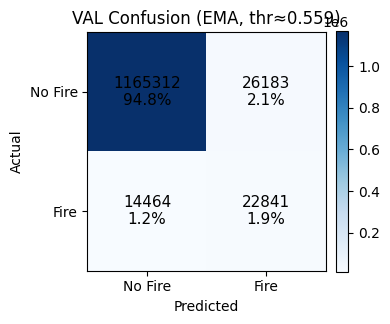

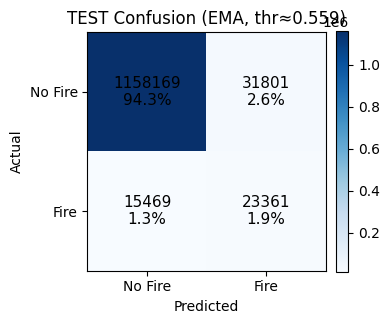

In [ ]:
import numpy as np

best_name, best_stats = max(final_metrics.items(), key=lambda kv: kv[1]["val_ap"])
best_model = variants[best_name]
best_thr = best_stats["val_thr"]
print(f"Using {best_name} weights for confusion/PR with thr≈{best_thr:.3f}")

@torch.no_grad()
def confusion_at_thr(model_obj, loader, thr):
    model_obj.eval()
    tp = fp = tn = fn = 0
    for batch in loader:
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        p = torch.sigmoid(logits).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy().astype(np.uint8)
        p = np.nan_to_num(p, nan=0.0)
        yhat = (p >= thr).astype(np.uint8)
        tp += np.logical_and(yhat == 1, t == 1).sum()
        fp += np.logical_and(yhat == 1, t == 0).sum()
        tn += np.logical_and(yhat == 0, t == 0).sum()
        fn += np.logical_and(yhat == 0, t == 1).sum()
    tp, fp, tn, fn = map(int, (tp, fp, tn, fn))
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)
    iou = tp / (tp + fp + fn + 1e-8)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                precision=float(prec), recall=float(rec), f1=float(f1), iou=float(iou))


def _conf_matrix_from_counts(stats):
    return np.array([[stats["tn"], stats["fp"]],
                     [stats["fn"], stats["tp"]]], dtype=np.int32)


def _plot_confusion(cm, title):
    total = cm.sum()
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["No Fire", "Fire"])
    ax.set_yticklabels(["No Fire", "Fire"])
    for (i, j), val in np.ndenumerate(cm):
        pct = (val / total * 100.0) if total else 0.0
        ax.text(j, i, f"{val}\n{pct:.1f}%", ha="center", va="center", color="black", fontsize=11)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()


val_stats = confusion_at_thr(best_model, val_loader, best_thr)
test_stats = confusion_at_thr(best_model, test_loader, best_thr)

print("VAL @thr:", val_stats)
print("TEST @thr:", test_stats)

_plot_confusion(_conf_matrix_from_counts(val_stats), f"VAL Confusion ({best_name}, thr≈{best_thr:.3f})")
_plot_confusion(_conf_matrix_from_counts(test_stats), f"TEST Confusion ({best_name}, thr≈{best_thr:.3f})")


TEST metrics: {'ap': 0.4510689066149429, 'best_f1': 0.4977369244229395, 'best_thr': 0.5072488784790039, 'chosen_thr': 0.5592116713523865, 'iou': 0.3307471223683183}
Confusion counts: {'TP': 23361.0, 'FP': 31801.0, 'FN': 15469.0}
Confusion matrix:
 [[1158169   31801]
 [  15469   23361]]


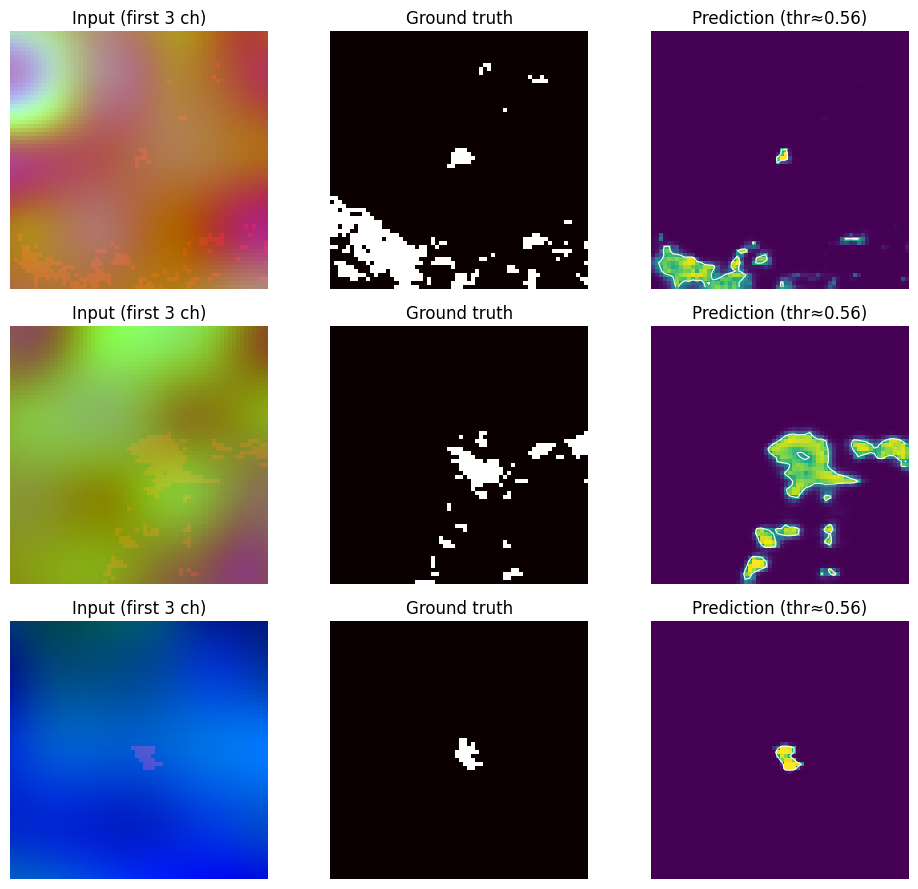

In [ ]:
# =========================================================
# Test-set evaluation + qualitative checks
# =========================================================
@torch.no_grad()
def run_test(model_obj, loader, threshold=None, desc="TEST eval"):
    model_obj.eval()
    probs_all, targets_all = [], []
    for batch in tqdm(loader, desc=desc, leave=False):
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        probs_all.append(torch.sigmoid(logits).detach().cpu())
        targets_all.append(y.detach().cpu())
    probs = torch.cat(probs_all, dim=0)
    targets = torch.cat(targets_all, dim=0)
    p_flat = probs.flatten().numpy()
    t_flat = targets.flatten().numpy()
    ap = average_precision_score(t_flat, p_flat)
    prec, rec, thr = precision_recall_curve(t_flat, p_flat)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr_curve = thr[best_idx] if best_idx < len(thr) else 0.5
    chosen_thr = float(threshold if threshold is not None else best_thr_curve)
    binary = (probs >= chosen_thr).float()
    tp = float((binary * targets).sum().item())
    fp = float((binary * (1 - targets)).sum().item())
    fn = float((((1 - binary) * targets)).sum().item())
    intersection = tp
    union = float(binary.sum().item() + targets.sum().item() - intersection)
    iou = intersection / (union + 1e-8)
    metrics = {
        "ap": float(ap),
        "best_f1": float(f1.max()),
        "best_thr": float(best_thr_curve),
        "chosen_thr": chosen_thr,
        "iou": float(iou),
    }
    confusion_counts = {"TP": tp, "FP": fp, "FN": fn}
    cm = confusion_matrix(t_flat.astype(int), binary.flatten().numpy().astype(int), labels=[0, 1])
    return metrics, confusion_counts, cm


test_metrics, test_confusion, test_cm = run_test(best_model, test_loader, threshold=best_thr, desc=f"TEST {best_name}")
print("TEST metrics:", test_metrics)
print("Confusion counts:", test_confusion)
print("Confusion matrix:\n", test_cm)


@torch.no_grad()
def visualize_predictions(loader, model_obj=None, n=4, threshold=None):
    if model_obj is None:
        model_obj = best_model
    thr = float(threshold if threshold is not None else test_metrics.get("chosen_thr", best_thr))
    loader_iter = iter(loader)
    fig, axes = plt.subplots(n, 3, figsize=(10, 3 * n))
    axes = np.atleast_2d(axes)
    for row in range(n):
        try:
            batch = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            batch = next(loader_iter)
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        prob = torch.sigmoid(logits).detach().cpu()
        x_raw = batch["X_raw"][0].cpu().numpy()
        img = x_raw[:3]
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        gt = y[0, 0].cpu().numpy()
        pred = prob[0, 0].numpy()
        axs = axes[row]
        axs[0].imshow(np.moveaxis(img, 0, -1))
        axs[0].set_title("Input (first 3 ch)")
        axs[0].axis("off")
        im1 = axs[1].imshow(gt, cmap="hot")
        axs[1].set_title("Ground truth")
        axs[1].axis("off")
        im2 = axs[2].imshow(pred, cmap="viridis")
        axs[2].contour(pred, levels=[thr], colors="white", linewidths=0.8)
        axs[2].set_title(f"Prediction (thr≈{thr:.2f})")
        axs[2].axis("off")
    plt.tight_layout()


visualize_predictions(test_loader, model_obj=best_model, n=3, threshold=test_metrics.get("chosen_thr", best_thr))

## 1.3 Comparison Graph


In [ ]:
@torch.no_grad()
def visualize_compare_models(
    loader,
    unet_model,
    lr_model,
    n=4,
    unet_thr=None,
    lr_thr=None,
):
    unet_model.eval()
    lr_model.eval()

    # Threshold defaults
    unet_thr = float(unet_thr)
    lr_thr = float(lr_thr)

    # Prepare figure: Input | GT | LR | U-Net
    it = iter(loader)
    fig, axes = plt.subplots(n, 4, figsize=(18, 4 * n))
    axes = np.atleast_2d(axes)

    # These will store the image handles used for colorbars
    im_lr = None
    im_unet = None

    for row in range(n):
        # Load next batch
        try:
            batch = next(it)
        except StopIteration:
            it = iter(loader)
            batch = next(it)

        # ----- INPUT IMAGE -----
        x_raw = batch["X_raw"][0].cpu().numpy()
        img = x_raw[:3]
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

        # ----- GROUND TRUTH -----
        y = batch["y"][0, 0].cpu().numpy()

        # ----- U-NET -----
        feats_unet, _ = _forward_batch(unet_model, batch)
        logits_unet = unet_model(feats_unet)
        prob_unet = torch.sigmoid(logits_unet)[0, 0].cpu().numpy()

        # ----- LR -----
        X_lr = build_lr_input(batch["X_raw"].to(feats_unet.device))
        logits_lr = lr_model(X_lr)
        prob_lr = torch.sigmoid(logits_lr)[0, 0].cpu().numpy()

        axs = axes[row]

        # --- Column 1: Input ---
        axs[0].imshow(np.moveaxis(img, 0, -1))
        axs[0].set_title("Input")
        axs[0].axis("off")

        # --- Column 2: Ground Truth ---
        axs[1].imshow(y, cmap="hot")
        axs[1].set_title("Ground Truth")
        axs[1].axis("off")

        # --- Column 3: LR Prediction ---
        im_lr = axs[2].imshow(prob_lr, cmap="viridis")
        axs[2].contour(prob_lr, levels=[lr_thr], colors="white", linewidths=0.9)
        axs[2].set_title(f"LR (thr≈{lr_thr:.2f})")
        axs[2].axis("off")

        # --- Column 4: U-Net Prediction ---
        im_unet = axs[3].imshow(prob_unet, cmap="viridis")
        axs[3].contour(prob_unet, levels=[unet_thr], colors="white", linewidths=0.9)
        axs[3].set_title(f"U-Net (thr≈{unet_thr:.2f})")
        axs[3].axis("off")

    # ============================================================
    #  COLORBARS (only once, spanning entire LR column & U-Net column)
    # ============================================================
    #fig.colorbar(im_lr, ax=axes[:, 2], fraction=0.02, pad=0.04, label="Probability")
    fig.colorbar(im_unet, ax=axes[:, 3], fraction=0.02, pad=0.04, label="Probability")

    #plt.tight_layout()
    plt.show()


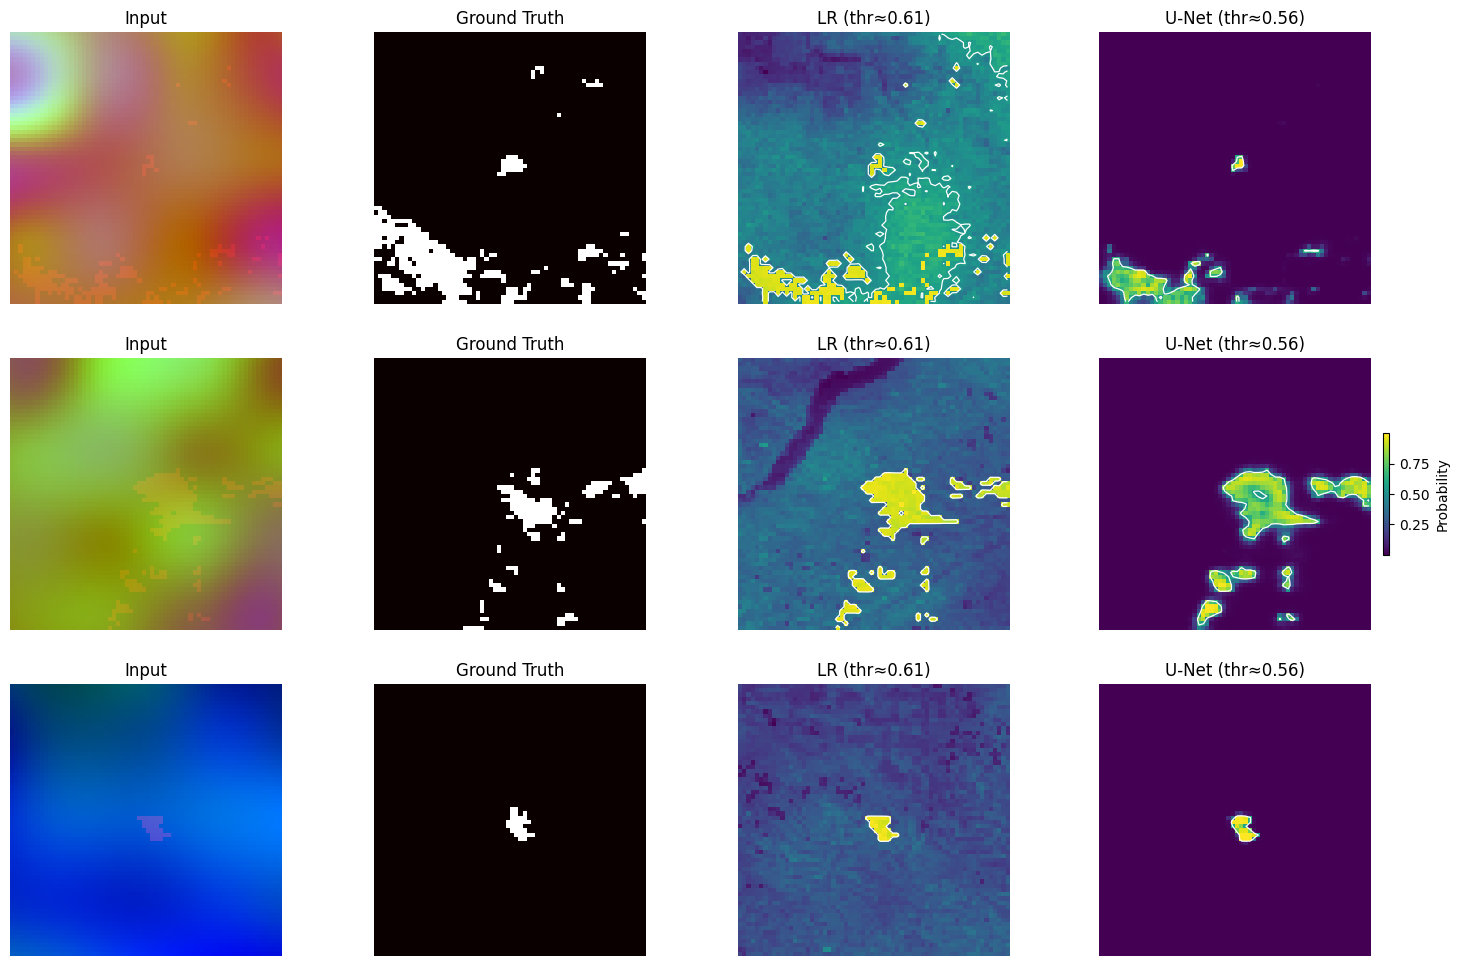

In [ ]:
visualize_compare_models(
    test_loader,
    unet_model=best_model,
    lr_model=lr_model,
    n=3,
    unet_thr=test_metrics["chosen_thr"],
    lr_thr=best_thr_val,
)

# Ablation 1: Feature Family

In [ ]:
minus_wind_channels = ['prev_fire',
 'temp',
 'rh',
 'ndvi',
 'slope',
 'aspect',
 'barrier',
 'erc',
 'pdsi',
 'pr',
 'bi',
 'chili',
 'fuel1',
 'fuel2',
 'fuel3',
 'impervious',
 'water']

In [ ]:
minus_fuel_channels = ['prev_fire',
 'u',
 'v',
 'temp',
 'rh',
 'ndvi',
 'slope',
 'aspect',
 'barrier',
 'erc',
 'pdsi',
 'pr',
 'bi',
 'chili',
 'impervious',
 'water',
 'wind_75',
 'gust_med']

In [ ]:
minus_vegd_channels = ['prev_fire',
 'u',
 'v',
 'temp',
 'rh',
 'slope',
 'aspect',
 'barrier',
 'erc',
 'pr',
 'bi',
 'chili',
 'fuel1',
 'fuel2',
 'fuel3',
 'impervious',
 'water',
 'wind_75',
 'gust_med']

In [ ]:
minus_topog_channels = ['prev_fire',
 'u',
 'v',
 'temp',
 'rh',
 'ndvi',
 'barrier',
 'erc',
 'pdsi',
 'pr',
 'bi',
 'chili',
 'impervious',
 'water',
 'wind_75',
 'gust_med']

# Ablation 2: Dependence on Previous Burn Mask

In [ ]:
WITHOUTBURN_CHANNELS = [
 'u',
 'v',
 'temp',
 'rh',
 'ndvi',
 'slope',
 'aspect',
 'barrier',
 'erc',
 'pdsi',
 'pr',
 'bi',
 'chili',
 'fuel1',
 'fuel2',
 'fuel3',
 'impervious',
 'water',
 'wind_75',
 'gust_med']

# 2. LogReg Ablations

minus wind

In [ ]:
# --- Reuse shared pipeline hookup from mNDWS_models ---
# configure_channels() honors the global USE_CHANNELS definition and supports ablations.
CHANNELS_FOR_MODEL = minus_wind_channels
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = mndws_models.pipeline_hookup(
    CHANNELS_FOR_MODEL=minus_wind_channels,
    BATCH_SIZE=16,
 )

def build_lr_input(X_raw0, mean=None, std=None):
    mean_t = mean if mean is not None else meanC
    std_t = std if std is not None else stdC
    return mndws_models.build_lr_input(X_raw0, mean_t, std_t)

print(f'Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}')

Channels configured (17): ['prev_fire', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water']
Channel stats computed -> torch.Size([17]) torch.Size([17])
Channels configured (17): ['prev_fire', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water']


In [ ]:
# =========================================================
# 4) Pixel Logistic Regression (1x1 conv) — uses shared module definition
# =========================================================
lr_model, pw, criterion, optimizer = mndws_models.PixelLogReg_outputs(
    train_ds=train_ds,
    meanC=meanC,
    stdC=stdC,
    train_loader=train_loader,
    device=device,
 )

# Change number of epochs for training here
EPOCHS_LR = 50

in_ch = 17 pos_weight = 34.63572692871094


In [ ]:
# =========================================================
# 5) Train / Eval loops, change number of epochs above
# =========================================================

# Shared artifact path so we can skip retraining when cached weights exist
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_thr_val = 0.5
cached_artifact = False
artifact = {}

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in lr_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)

if os.path.exists(ART_PATH):
    print(f"Loading cached PixelLogReg artifact from {ART_PATH}")
    artifact = torch.load(ART_PATH, map_location=device)
    saved_channels = artifact.get("channels")
    current_channels = list(train_ds.channels)
    if saved_channels == current_channels:
        lr_model.load_state_dict(artifact["state_dict"])
        best_thr_val = float(artifact.get("best_thr", 0.5))
        train_loss_hist = list(artifact.get("train_loss_hist", []))
        val_ap_hist = list(artifact.get("val_ap_hist", []))
        val_f1_hist = list(artifact.get("val_f1_hist", []))
        val_thr_hist = list(artifact.get("val_thr_hist", []))
        val_iou_hist = list(artifact.get("val_iou_hist", []))
        compute_metrics.update(artifact.get("compute_metrics", {}))
        cached_artifact = True
    else:
        print("Cached artifact channel order differs from requested dataset; retraining.")
else:
    print("No cached PixelLogReg artifact found; training from scratch.")

if not cached_artifact:
    best_val_ap_lr = -1.0
    best_state = None

    for e in range(EPOCHS_LR):
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_start = time.perf_counter()
        tr_loss, tiles_seen = train_lr_epoch()
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_duration = time.perf_counter() - epoch_start
        epoch_times.append(epoch_duration)
        epoch_tiles.append(tiles_seen)
        ap, f1, thr, iou = eval_lr(val_loader)
        train_loss_hist.append(tr_loss)
        val_ap_hist.append(ap)
        val_f1_hist.append(f1)
        val_thr_hist.append(thr)
        val_iou_hist.append(iou)
        print(f"[LR] Epoch {e:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
        if ap > best_val_ap_lr:
            best_val_ap_lr = ap
            best_state = {k: v.cpu().clone() for k, v in lr_model.state_dict().items()}

    if best_state is not None:
        lr_model.load_state_dict(best_state)

    _, _, best_thr_val, best_iou_val = eval_lr(val_loader)
    if val_thr_hist:
        val_thr_hist[-1] = best_thr_val
    else:
        val_thr_hist.append(best_thr_val)
    if val_iou_hist:
        val_iou_hist[-1] = best_iou_val
    else:
        val_iou_hist.append(best_iou_val)

    if epoch_times:
        avg_epoch = float(np.mean(epoch_times))
        std_epoch = float(np.std(epoch_times))
        total_time = float(np.sum(epoch_times))
        total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
        throughput = float(total_tiles / total_time) if total_time > 0 else None
    else:
        avg_epoch = std_epoch = throughput = None
    if use_cuda:
        torch.cuda.synchronize(device)
        peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
    elif use_mps:
        torch.mps.synchronize()
    latency_s = None
else:
    if not val_thr_hist:
        val_ap, val_f1, best_thr_val, best_iou_val = eval_lr(val_loader)
        val_ap_hist = [val_ap]
        val_f1_hist = [val_f1]
        val_thr_hist = [best_thr_val]
        val_iou_hist = [best_iou_val]
        print("Cached artifact missing history; recomputed validation metrics.")
    else:
        best_thr_val = float(artifact.get("best_thr", val_thr_hist[-1]))
        if not val_iou_hist:
            _, _, _, best_iou_val = eval_lr(val_loader)
            val_iou_hist = [best_iou_val]
    avg_epoch = compute_metrics.get("avg_epoch", None)
    std_epoch = compute_metrics.get("std_epoch", None)
    throughput = compute_metrics.get("throughput_tiles_per_s", None)
    peak_gpu_gb = compute_metrics.get("peak_gpu_gb", None)
    latency_s = compute_metrics.get("latency_s", None)

test_ap_lr, test_f1_lr, test_iou_lr = test_at_thr(best_thr_val)

'''
if latency_s is None:
    latency_s = measure_latency(test_ds, repeats=100)
if use_cuda and peak_gpu_gb is None:
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})
'''

Loading cached PixelLogReg artifact from /root/wildfire_artifacts/lr/pixel_logreg.pt
Cached artifact channel order differs from requested dataset; retraining.


[LR] Epoch 00 | loss 1.3753 | VAL AP 0.0349 | VAL F1* 0.0679 | VAL IoU 0.0352 | thr≈0.540


[LR] Epoch 01 | loss 1.3611 | VAL AP 0.0487 | VAL F1* 0.0960 | VAL IoU 0.0504 | thr≈0.599


[LR] Epoch 02 | loss 1.2931 | VAL AP 0.0606 | VAL F1* 0.1215 | VAL IoU 0.0647 | thr≈0.624


[LR] Epoch 03 | loss 1.2872 | VAL AP 0.0703 | VAL F1* 0.1428 | VAL IoU 0.0769 | thr≈0.639


[LR] Epoch 04 | loss 1.2606 | VAL AP 0.0786 | VAL F1* 0.1578 | VAL IoU 0.0857 | thr≈0.646


[LR] Epoch 05 | loss 1.2130 | VAL AP 0.0839 | VAL F1* 0.1662 | VAL IoU 0.0907 | thr≈0.659


[LR] Epoch 06 | loss 1.2407 | VAL AP 0.0914 | VAL F1* 0.1778 | VAL IoU 0.0976 | thr≈0.672


[LR] Epoch 07 | loss 1.2156 | VAL AP 0.1014 | VAL F1* 0.1912 | VAL IoU 0.1057 | thr≈0.677


[LR] Epoch 08 | loss 1.2000 | VAL AP 0.1122 | VAL F1* 0.2056 | VAL IoU 0.1146 | thr≈0.690


[LR] Epoch 09 | loss 1.1711 | VAL AP 0.1234 | VAL F1* 0.2190 | VAL IoU 0.1230 | thr≈0.685


[LR] Epoch 10 | loss 1.1433 | VAL AP 0.1372 | VAL F1* 0.2338 | VAL IoU 0.1324 | thr≈0.697


[LR] Epoch 11 | loss 1.1601 | VAL AP 0.1456 | VAL F1* 0.2436 | VAL IoU 0.1387 | thr≈0.704


[LR] Epoch 12 | loss 1.1497 | VAL AP 0.1566 | VAL F1* 0.2567 | VAL IoU 0.1472 | thr≈0.716


[LR] Epoch 13 | loss 1.1738 | VAL AP 0.1664 | VAL F1* 0.2674 | VAL IoU 0.1543 | thr≈0.730


[LR] Epoch 14 | loss 1.0978 | VAL AP 0.1799 | VAL F1* 0.2836 | VAL IoU 0.1652 | thr≈0.722


[LR] Epoch 15 | loss 1.1022 | VAL AP 0.1915 | VAL F1* 0.2984 | VAL IoU 0.1753 | thr≈0.726


[LR] Epoch 16 | loss 1.0729 | VAL AP 0.2016 | VAL F1* 0.3111 | VAL IoU 0.1842 | thr≈0.728


[LR] Epoch 17 | loss 1.1328 | VAL AP 0.2088 | VAL F1* 0.3178 | VAL IoU 0.1889 | thr≈0.734


[LR] Epoch 18 | loss 1.0896 | VAL AP 0.2146 | VAL F1* 0.3249 | VAL IoU 0.1939 | thr≈0.740


[LR] Epoch 19 | loss 1.0405 | VAL AP 0.2201 | VAL F1* 0.3325 | VAL IoU 0.1994 | thr≈0.739


[LR] Epoch 20 | loss 1.0474 | VAL AP 0.2284 | VAL F1* 0.3441 | VAL IoU 0.2078 | thr≈0.736


[LR] Epoch 21 | loss 1.0646 | VAL AP 0.2325 | VAL F1* 0.3508 | VAL IoU 0.2127 | thr≈0.735


[LR] Epoch 22 | loss 1.1133 | VAL AP 0.2347 | VAL F1* 0.3557 | VAL IoU 0.2164 | thr≈0.740


[LR] Epoch 23 | loss 1.1245 | VAL AP 0.2406 | VAL F1* 0.3664 | VAL IoU 0.2243 | thr≈0.745


[LR] Epoch 24 | loss 1.0781 | VAL AP 0.2437 | VAL F1* 0.3732 | VAL IoU 0.2294 | thr≈0.746


[LR] Epoch 25 | loss 1.0688 | VAL AP 0.2484 | VAL F1* 0.3854 | VAL IoU 0.2387 | thr≈0.738


[LR] Epoch 26 | loss 1.0442 | VAL AP 0.2529 | VAL F1* 0.3957 | VAL IoU 0.2467 | thr≈0.734


[LR] Epoch 27 | loss 1.0848 | VAL AP 0.2537 | VAL F1* 0.3960 | VAL IoU 0.2469 | thr≈0.752


[LR] Epoch 28 | loss 1.0716 | VAL AP 0.2550 | VAL F1* 0.3999 | VAL IoU 0.2499 | thr≈0.750


[LR] Epoch 29 | loss 1.0327 | VAL AP 0.2555 | VAL F1* 0.4022 | VAL IoU 0.2517 | thr≈0.747


[LR] Epoch 30 | loss 1.0444 | VAL AP 0.2569 | VAL F1* 0.4066 | VAL IoU 0.2552 | thr≈0.748


[LR] Epoch 31 | loss 1.0082 | VAL AP 0.2579 | VAL F1* 0.4094 | VAL IoU 0.2574 | thr≈0.756


[LR] Epoch 32 | loss 1.0468 | VAL AP 0.2591 | VAL F1* 0.4147 | VAL IoU 0.2616 | thr≈0.759


[LR] Epoch 33 | loss 1.0293 | VAL AP 0.2582 | VAL F1* 0.4139 | VAL IoU 0.2609 | thr≈0.759


[LR] Epoch 34 | loss 1.0356 | VAL AP 0.2587 | VAL F1* 0.4167 | VAL IoU 0.2632 | thr≈0.765


[LR] Epoch 35 | loss 1.0536 | VAL AP 0.2605 | VAL F1* 0.4201 | VAL IoU 0.2659 | thr≈0.775


[LR] Epoch 36 | loss 1.0455 | VAL AP 0.2608 | VAL F1* 0.4232 | VAL IoU 0.2684 | thr≈0.770


[LR] Epoch 37 | loss 1.0493 | VAL AP 0.2608 | VAL F1* 0.4234 | VAL IoU 0.2685 | thr≈0.777


[LR] Epoch 38 | loss 1.0327 | VAL AP 0.2609 | VAL F1* 0.4257 | VAL IoU 0.2704 | thr≈0.778


[LR] Epoch 39 | loss 1.0101 | VAL AP 0.2608 | VAL F1* 0.4257 | VAL IoU 0.2704 | thr≈0.782


[LR] Epoch 40 | loss 1.0228 | VAL AP 0.2615 | VAL F1* 0.4282 | VAL IoU 0.2724 | thr≈0.785


[LR] Epoch 41 | loss 1.0187 | VAL AP 0.2611 | VAL F1* 0.4272 | VAL IoU 0.2716 | thr≈0.789


[LR] Epoch 42 | loss 1.0082 | VAL AP 0.2608 | VAL F1* 0.4286 | VAL IoU 0.2728 | thr≈0.774


[LR] Epoch 43 | loss 0.9845 | VAL AP 0.2610 | VAL F1* 0.4301 | VAL IoU 0.2739 | thr≈0.776


[LR] Epoch 44 | loss 1.0445 | VAL AP 0.2599 | VAL F1* 0.4280 | VAL IoU 0.2722 | thr≈0.780


[LR] Epoch 45 | loss 1.0044 | VAL AP 0.2611 | VAL F1* 0.4292 | VAL IoU 0.2732 | thr≈0.787


[LR] Epoch 46 | loss 1.0364 | VAL AP 0.2607 | VAL F1* 0.4294 | VAL IoU 0.2734 | thr≈0.791


[LR] Epoch 47 | loss 0.9891 | VAL AP 0.2618 | VAL F1* 0.4319 | VAL IoU 0.2754 | thr≈0.780


[LR] Epoch 48 | loss 1.0091 | VAL AP 0.2613 | VAL F1* 0.4314 | VAL IoU 0.2750 | thr≈0.784


[LR] Epoch 49 | loss 1.0530 | VAL AP 0.2611 | VAL F1* 0.4338 | VAL IoU 0.2769 | thr≈0.789


[LR] TEST @thr=0.780 | AP=0.2231 | P=0.388 R=0.453 F1=0.418 IoU=0.264


'\nif latency_s is None:\n    latency_s = measure_latency(test_ds, repeats=100)\nif use_cuda and peak_gpu_gb is None:\n    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))\n\ncompute_metrics.update({\n    "avg_epoch": avg_epoch,\n    "std_epoch": std_epoch,\n    "throughput_tiles_per_s": throughput,\n    "peak_gpu_gb": peak_gpu_gb,\n    "latency_s": latency_s,\n})\n'

minus fuel

In [ ]:
# --- Reuse shared pipeline hookup from mNDWS_models ---
# configure_channels() honors the global USE_CHANNELS definition and supports ablations.
CHANNELS_FOR_MODEL = minus_fuel_channels
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = mndws_models.pipeline_hookup(
    CHANNELS_FOR_MODEL=minus_fuel_channels,
    BATCH_SIZE=16,
 )

def build_lr_input(X_raw0, mean=None, std=None):
    mean_t = mean if mean is not None else meanC
    std_t = std if std is not None else stdC
    return mndws_models.build_lr_input(X_raw0, mean_t, std_t)

print(f'Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}')

Channels configured (18): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([18]) torch.Size([18])
Channels configured (18): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'impervious', 'water', 'wind_75', 'gust_med']


In [ ]:
# =========================================================
# 4) Pixel Logistic Regression (1x1 conv) — uses shared module definition
# =========================================================
lr_model, pw, criterion, optimizer = mndws_models.PixelLogReg_outputs(
    train_ds=train_ds,
    meanC=meanC,
    stdC=stdC,
    train_loader=train_loader,
    device=device,
 )

# Change number of epochs for training here
EPOCHS_LR = 50

in_ch = 18 pos_weight = 35.56081771850586


In [ ]:
# =========================================================
# 5) Train / Eval loops, change number of epochs above
# =========================================================

# Shared artifact path so we can skip retraining when cached weights exist
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_thr_val = 0.5
cached_artifact = False
artifact = {}

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in lr_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)

if os.path.exists(ART_PATH):
    print(f"Loading cached PixelLogReg artifact from {ART_PATH}")
    artifact = torch.load(ART_PATH, map_location=device)
    saved_channels = artifact.get("channels")
    current_channels = list(train_ds.channels)
    if saved_channels == current_channels:
        lr_model.load_state_dict(artifact["state_dict"])
        best_thr_val = float(artifact.get("best_thr", 0.5))
        train_loss_hist = list(artifact.get("train_loss_hist", []))
        val_ap_hist = list(artifact.get("val_ap_hist", []))
        val_f1_hist = list(artifact.get("val_f1_hist", []))
        val_thr_hist = list(artifact.get("val_thr_hist", []))
        val_iou_hist = list(artifact.get("val_iou_hist", []))
        compute_metrics.update(artifact.get("compute_metrics", {}))
        cached_artifact = True
    else:
        print("Cached artifact channel order differs from requested dataset; retraining.")
else:
    print("No cached PixelLogReg artifact found; training from scratch.")

if not cached_artifact:
    best_val_ap_lr = -1.0
    best_state = None

    for e in range(EPOCHS_LR):
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_start = time.perf_counter()
        tr_loss, tiles_seen = train_lr_epoch()
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_duration = time.perf_counter() - epoch_start
        epoch_times.append(epoch_duration)
        epoch_tiles.append(tiles_seen)
        ap, f1, thr, iou = eval_lr(val_loader)
        train_loss_hist.append(tr_loss)
        val_ap_hist.append(ap)
        val_f1_hist.append(f1)
        val_thr_hist.append(thr)
        val_iou_hist.append(iou)
        print(f"[LR] Epoch {e:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
        if ap > best_val_ap_lr:
            best_val_ap_lr = ap
            best_state = {k: v.cpu().clone() for k, v in lr_model.state_dict().items()}

    if best_state is not None:
        lr_model.load_state_dict(best_state)

    _, _, best_thr_val, best_iou_val = eval_lr(val_loader)
    if val_thr_hist:
        val_thr_hist[-1] = best_thr_val
    else:
        val_thr_hist.append(best_thr_val)
    if val_iou_hist:
        val_iou_hist[-1] = best_iou_val
    else:
        val_iou_hist.append(best_iou_val)

    if epoch_times:
        avg_epoch = float(np.mean(epoch_times))
        std_epoch = float(np.std(epoch_times))
        total_time = float(np.sum(epoch_times))
        total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
        throughput = float(total_tiles / total_time) if total_time > 0 else None
    else:
        avg_epoch = std_epoch = throughput = None
    if use_cuda:
        torch.cuda.synchronize(device)
        peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
    elif use_mps:
        torch.mps.synchronize()
    latency_s = None
else:
    if not val_thr_hist:
        val_ap, val_f1, best_thr_val, best_iou_val = eval_lr(val_loader)
        val_ap_hist = [val_ap]
        val_f1_hist = [val_f1]
        val_thr_hist = [best_thr_val]
        val_iou_hist = [best_iou_val]
        print("Cached artifact missing history; recomputed validation metrics.")
    else:
        best_thr_val = float(artifact.get("best_thr", val_thr_hist[-1]))
        if not val_iou_hist:
            _, _, _, best_iou_val = eval_lr(val_loader)
            val_iou_hist = [best_iou_val]
    avg_epoch = compute_metrics.get("avg_epoch", None)
    std_epoch = compute_metrics.get("std_epoch", None)
    throughput = compute_metrics.get("throughput_tiles_per_s", None)
    peak_gpu_gb = compute_metrics.get("peak_gpu_gb", None)
    latency_s = compute_metrics.get("latency_s", None)

test_ap_lr, test_f1_lr, test_iou_lr = test_at_thr(best_thr_val)
'''
if latency_s is None:
    latency_s = measure_latency(test_ds, repeats=100)
if use_cuda and peak_gpu_gb is None:
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})
'''

Loading cached PixelLogReg artifact from /root/wildfire_artifacts/lr/pixel_logreg.pt
Cached artifact channel order differs from requested dataset; retraining.


[LR] Epoch 00 | loss 1.4092 | VAL AP 0.0382 | VAL F1* 0.0763 | VAL IoU 0.0397 | thr≈0.522


[LR] Epoch 01 | loss 1.3435 | VAL AP 0.0577 | VAL F1* 0.1245 | VAL IoU 0.0664 | thr≈0.571


[LR] Epoch 02 | loss 1.3049 | VAL AP 0.0863 | VAL F1* 0.1757 | VAL IoU 0.0963 | thr≈0.619


[LR] Epoch 03 | loss 1.2584 | VAL AP 0.1075 | VAL F1* 0.2084 | VAL IoU 0.1164 | thr≈0.641


[LR] Epoch 04 | loss 1.2446 | VAL AP 0.1236 | VAL F1* 0.2337 | VAL IoU 0.1323 | thr≈0.659


[LR] Epoch 05 | loss 1.1872 | VAL AP 0.1311 | VAL F1* 0.2429 | VAL IoU 0.1383 | thr≈0.679


[LR] Epoch 06 | loss 1.1763 | VAL AP 0.1361 | VAL F1* 0.2508 | VAL IoU 0.1434 | thr≈0.695


[LR] Epoch 07 | loss 1.1741 | VAL AP 0.1395 | VAL F1* 0.2556 | VAL IoU 0.1465 | thr≈0.705


[LR] Epoch 08 | loss 1.1764 | VAL AP 0.1493 | VAL F1* 0.2673 | VAL IoU 0.1543 | thr≈0.709


[LR] Epoch 09 | loss 1.1380 | VAL AP 0.1581 | VAL F1* 0.2783 | VAL IoU 0.1616 | thr≈0.709


[LR] Epoch 10 | loss 1.1267 | VAL AP 0.1594 | VAL F1* 0.2812 | VAL IoU 0.1636 | thr≈0.710


[LR] Epoch 11 | loss 1.1144 | VAL AP 0.1660 | VAL F1* 0.2887 | VAL IoU 0.1687 | thr≈0.708


[LR] Epoch 12 | loss 1.1546 | VAL AP 0.1763 | VAL F1* 0.2992 | VAL IoU 0.1759 | thr≈0.714


[LR] Epoch 13 | loss 1.1208 | VAL AP 0.1888 | VAL F1* 0.3111 | VAL IoU 0.1842 | thr≈0.727


[LR] Epoch 14 | loss 1.1251 | VAL AP 0.2025 | VAL F1* 0.3271 | VAL IoU 0.1955 | thr≈0.734


[LR] Epoch 15 | loss 1.1001 | VAL AP 0.2072 | VAL F1* 0.3350 | VAL IoU 0.2012 | thr≈0.723


[LR] Epoch 16 | loss 1.0798 | VAL AP 0.2124 | VAL F1* 0.3436 | VAL IoU 0.2074 | thr≈0.729


[LR] Epoch 17 | loss 1.1065 | VAL AP 0.2152 | VAL F1* 0.3482 | VAL IoU 0.2108 | thr≈0.731


[LR] Epoch 18 | loss 1.1123 | VAL AP 0.2179 | VAL F1* 0.3491 | VAL IoU 0.2115 | thr≈0.739


[LR] Epoch 19 | loss 1.1108 | VAL AP 0.2269 | VAL F1* 0.3608 | VAL IoU 0.2201 | thr≈0.740


[LR] Epoch 20 | loss 1.0606 | VAL AP 0.2357 | VAL F1* 0.3760 | VAL IoU 0.2315 | thr≈0.737


[LR] Epoch 21 | loss 1.0794 | VAL AP 0.2377 | VAL F1* 0.3805 | VAL IoU 0.2349 | thr≈0.740


[LR] Epoch 22 | loss 1.0477 | VAL AP 0.2403 | VAL F1* 0.3866 | VAL IoU 0.2396 | thr≈0.741


[LR] Epoch 23 | loss 1.0459 | VAL AP 0.2415 | VAL F1* 0.3871 | VAL IoU 0.2400 | thr≈0.749


[LR] Epoch 24 | loss 1.0632 | VAL AP 0.2408 | VAL F1* 0.3859 | VAL IoU 0.2391 | thr≈0.747


[LR] Epoch 25 | loss 1.0853 | VAL AP 0.2422 | VAL F1* 0.3888 | VAL IoU 0.2413 | thr≈0.754


[LR] Epoch 26 | loss 1.0717 | VAL AP 0.2444 | VAL F1* 0.3938 | VAL IoU 0.2452 | thr≈0.768


[LR] Epoch 27 | loss 1.0595 | VAL AP 0.2457 | VAL F1* 0.4002 | VAL IoU 0.2502 | thr≈0.777


[LR] Epoch 28 | loss 1.0630 | VAL AP 0.2461 | VAL F1* 0.4017 | VAL IoU 0.2514 | thr≈0.769


[LR] Epoch 29 | loss 1.0801 | VAL AP 0.2439 | VAL F1* 0.3985 | VAL IoU 0.2488 | thr≈0.779


[LR] Epoch 30 | loss 1.0187 | VAL AP 0.2424 | VAL F1* 0.3938 | VAL IoU 0.2452 | thr≈0.780


[LR] Epoch 31 | loss 1.0505 | VAL AP 0.2467 | VAL F1* 0.4008 | VAL IoU 0.2506 | thr≈0.785


[LR] Epoch 32 | loss 1.0258 | VAL AP 0.2492 | VAL F1* 0.4077 | VAL IoU 0.2561 | thr≈0.783


[LR] Epoch 33 | loss 1.0624 | VAL AP 0.2475 | VAL F1* 0.4080 | VAL IoU 0.2563 | thr≈0.787


[LR] Epoch 34 | loss 1.0547 | VAL AP 0.2489 | VAL F1* 0.4138 | VAL IoU 0.2609 | thr≈0.789


[LR] Epoch 35 | loss 1.0142 | VAL AP 0.2474 | VAL F1* 0.4123 | VAL IoU 0.2597 | thr≈0.794


[LR] Epoch 36 | loss 1.0286 | VAL AP 0.2491 | VAL F1* 0.4160 | VAL IoU 0.2626 | thr≈0.796


[LR] Epoch 37 | loss 1.0106 | VAL AP 0.2493 | VAL F1* 0.4155 | VAL IoU 0.2622 | thr≈0.803


[LR] Epoch 38 | loss 1.0401 | VAL AP 0.2495 | VAL F1* 0.4168 | VAL IoU 0.2633 | thr≈0.809


[LR] Epoch 39 | loss 1.0426 | VAL AP 0.2502 | VAL F1* 0.4205 | VAL IoU 0.2662 | thr≈0.799


[LR] Epoch 40 | loss 1.0318 | VAL AP 0.2501 | VAL F1* 0.4208 | VAL IoU 0.2665 | thr≈0.804


[LR] Epoch 41 | loss 1.0186 | VAL AP 0.2506 | VAL F1* 0.4219 | VAL IoU 0.2673 | thr≈0.796


[LR] Epoch 42 | loss 1.0353 | VAL AP 0.2507 | VAL F1* 0.4229 | VAL IoU 0.2681 | thr≈0.816


[LR] Epoch 43 | loss 1.0417 | VAL AP 0.2515 | VAL F1* 0.4251 | VAL IoU 0.2699 | thr≈0.803


[LR] Epoch 44 | loss 1.0249 | VAL AP 0.2515 | VAL F1* 0.4278 | VAL IoU 0.2721 | thr≈0.808


[LR] Epoch 45 | loss 1.0217 | VAL AP 0.2520 | VAL F1* 0.4285 | VAL IoU 0.2727 | thr≈0.792


[LR] Epoch 46 | loss 1.0182 | VAL AP 0.2521 | VAL F1* 0.4291 | VAL IoU 0.2732 | thr≈0.796


[LR] Epoch 47 | loss 0.9985 | VAL AP 0.2501 | VAL F1* 0.4291 | VAL IoU 0.2732 | thr≈0.797


[LR] Epoch 48 | loss 0.9741 | VAL AP 0.2515 | VAL F1* 0.4299 | VAL IoU 0.2738 | thr≈0.798


[LR] Epoch 49 | loss 0.9931 | VAL AP 0.2516 | VAL F1* 0.4316 | VAL IoU 0.2752 | thr≈0.798


[LR] TEST @thr=0.796 | AP=0.2285 | P=0.383 R=0.449 F1=0.413 IoU=0.261


'\nif latency_s is None:\n    latency_s = measure_latency(test_ds, repeats=100)\nif use_cuda and peak_gpu_gb is None:\n    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))\n\ncompute_metrics.update({\n    "avg_epoch": avg_epoch,\n    "std_epoch": std_epoch,\n    "throughput_tiles_per_s": throughput,\n    "peak_gpu_gb": peak_gpu_gb,\n    "latency_s": latency_s,\n})\n'

minus veg and drought

In [ ]:
# --- Reuse shared pipeline hookup from mNDWS_models ---
# configure_channels() honors the global USE_CHANNELS definition and supports ablations.
CHANNELS_FOR_MODEL = minus_vegd_channels
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = mndws_models.pipeline_hookup(
    CHANNELS_FOR_MODEL=minus_vegd_channels,
    BATCH_SIZE=16,
 )

def build_lr_input(X_raw0, mean=None, std=None):
    mean_t = mean if mean is not None else meanC
    std_t = std if std is not None else stdC
    return mndws_models.build_lr_input(X_raw0, mean_t, std_t)

print(f'Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}')

Channels configured (19): ['prev_fire', 'u', 'v', 'temp', 'rh', 'slope', 'aspect', 'barrier', 'erc', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([19]) torch.Size([19])
Channels configured (19): ['prev_fire', 'u', 'v', 'temp', 'rh', 'slope', 'aspect', 'barrier', 'erc', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']


In [ ]:
# =========================================================
# 4) Pixel Logistic Regression (1x1 conv) — uses shared module definition
# =========================================================
lr_model, pw, criterion, optimizer = mndws_models.PixelLogReg_outputs(
    train_ds=train_ds,
    meanC=meanC,
    stdC=stdC,
    train_loader=train_loader,
    device=device,
 )

# Change number of epochs for training here
EPOCHS_LR = 50

in_ch = 19 pos_weight = 34.170372009277344


In [ ]:
# =========================================================
# 5) Train / Eval loops, change number of epochs above
# =========================================================

# Shared artifact path so we can skip retraining when cached weights exist
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_thr_val = 0.5
cached_artifact = False
artifact = {}

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in lr_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)

if os.path.exists(ART_PATH):
    print(f"Loading cached PixelLogReg artifact from {ART_PATH}")
    artifact = torch.load(ART_PATH, map_location=device)
    saved_channels = artifact.get("channels")
    current_channels = list(train_ds.channels)
    if saved_channels == current_channels:
        lr_model.load_state_dict(artifact["state_dict"])
        best_thr_val = float(artifact.get("best_thr", 0.5))
        train_loss_hist = list(artifact.get("train_loss_hist", []))
        val_ap_hist = list(artifact.get("val_ap_hist", []))
        val_f1_hist = list(artifact.get("val_f1_hist", []))
        val_thr_hist = list(artifact.get("val_thr_hist", []))
        val_iou_hist = list(artifact.get("val_iou_hist", []))
        compute_metrics.update(artifact.get("compute_metrics", {}))
        cached_artifact = True
    else:
        print("Cached artifact channel order differs from requested dataset; retraining.")
else:
    print("No cached PixelLogReg artifact found; training from scratch.")

if not cached_artifact:
    best_val_ap_lr = -1.0
    best_state = None

    for e in range(EPOCHS_LR):
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_start = time.perf_counter()
        tr_loss, tiles_seen = train_lr_epoch()
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_duration = time.perf_counter() - epoch_start
        epoch_times.append(epoch_duration)
        epoch_tiles.append(tiles_seen)
        ap, f1, thr, iou = eval_lr(val_loader)
        train_loss_hist.append(tr_loss)
        val_ap_hist.append(ap)
        val_f1_hist.append(f1)
        val_thr_hist.append(thr)
        val_iou_hist.append(iou)
        print(f"[LR] Epoch {e:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
        if ap > best_val_ap_lr:
            best_val_ap_lr = ap
            best_state = {k: v.cpu().clone() for k, v in lr_model.state_dict().items()}

    if best_state is not None:
        lr_model.load_state_dict(best_state)

    _, _, best_thr_val, best_iou_val = eval_lr(val_loader)
    if val_thr_hist:
        val_thr_hist[-1] = best_thr_val
    else:
        val_thr_hist.append(best_thr_val)
    if val_iou_hist:
        val_iou_hist[-1] = best_iou_val
    else:
        val_iou_hist.append(best_iou_val)

    if epoch_times:
        avg_epoch = float(np.mean(epoch_times))
        std_epoch = float(np.std(epoch_times))
        total_time = float(np.sum(epoch_times))
        total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
        throughput = float(total_tiles / total_time) if total_time > 0 else None
    else:
        avg_epoch = std_epoch = throughput = None
    if use_cuda:
        torch.cuda.synchronize(device)
        peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
    elif use_mps:
        torch.mps.synchronize()
    latency_s = None
else:
    if not val_thr_hist:
        val_ap, val_f1, best_thr_val, best_iou_val = eval_lr(val_loader)
        val_ap_hist = [val_ap]
        val_f1_hist = [val_f1]
        val_thr_hist = [best_thr_val]
        val_iou_hist = [best_iou_val]
        print("Cached artifact missing history; recomputed validation metrics.")
    else:
        best_thr_val = float(artifact.get("best_thr", val_thr_hist[-1]))
        if not val_iou_hist:
            _, _, _, best_iou_val = eval_lr(val_loader)
            val_iou_hist = [best_iou_val]
    avg_epoch = compute_metrics.get("avg_epoch", None)
    std_epoch = compute_metrics.get("std_epoch", None)
    throughput = compute_metrics.get("throughput_tiles_per_s", None)
    peak_gpu_gb = compute_metrics.get("peak_gpu_gb", None)
    latency_s = compute_metrics.get("latency_s", None)

test_ap_lr, test_f1_lr, test_iou_lr = test_at_thr(best_thr_val)

'''
if latency_s is None:
    latency_s = measure_latency(test_ds, repeats=100)
if use_cuda and peak_gpu_gb is None:
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})
'''

Loading cached PixelLogReg artifact from /root/wildfire_artifacts/lr/pixel_logreg.pt
Cached artifact channel order differs from requested dataset; retraining.


[LR] Epoch 00 | loss 1.3510 | VAL AP 0.0482 | VAL F1* 0.0888 | VAL IoU 0.0465 | thr≈0.602


[LR] Epoch 01 | loss 1.2222 | VAL AP 0.0585 | VAL F1* 0.1090 | VAL IoU 0.0577 | thr≈0.618


[LR] Epoch 02 | loss 1.2478 | VAL AP 0.0680 | VAL F1* 0.1289 | VAL IoU 0.0689 | thr≈0.634


[LR] Epoch 03 | loss 1.2696 | VAL AP 0.0779 | VAL F1* 0.1477 | VAL IoU 0.0798 | thr≈0.648


[LR] Epoch 04 | loss 1.1920 | VAL AP 0.0855 | VAL F1* 0.1633 | VAL IoU 0.0889 | thr≈0.643


[LR] Epoch 05 | loss 1.2206 | VAL AP 0.0945 | VAL F1* 0.1796 | VAL IoU 0.0987 | thr≈0.658


[LR] Epoch 06 | loss 1.2162 | VAL AP 0.1040 | VAL F1* 0.1952 | VAL IoU 0.1082 | thr≈0.664


[LR] Epoch 07 | loss 1.1513 | VAL AP 0.1118 | VAL F1* 0.2080 | VAL IoU 0.1161 | thr≈0.664


[LR] Epoch 08 | loss 1.1445 | VAL AP 0.1199 | VAL F1* 0.2212 | VAL IoU 0.1244 | thr≈0.664


[LR] Epoch 09 | loss 1.1168 | VAL AP 0.1299 | VAL F1* 0.2365 | VAL IoU 0.1341 | thr≈0.669


[LR] Epoch 10 | loss 1.1482 | VAL AP 0.1364 | VAL F1* 0.2460 | VAL IoU 0.1402 | thr≈0.682


[LR] Epoch 11 | loss 1.1183 | VAL AP 0.1399 | VAL F1* 0.2536 | VAL IoU 0.1452 | thr≈0.686


[LR] Epoch 12 | loss 1.1474 | VAL AP 0.1466 | VAL F1* 0.2653 | VAL IoU 0.1529 | thr≈0.693


[LR] Epoch 13 | loss 1.1156 | VAL AP 0.1589 | VAL F1* 0.2815 | VAL IoU 0.1638 | thr≈0.690


[LR] Epoch 14 | loss 1.1183 | VAL AP 0.1670 | VAL F1* 0.2909 | VAL IoU 0.1702 | thr≈0.703


[LR] Epoch 15 | loss 1.1419 | VAL AP 0.1767 | VAL F1* 0.3013 | VAL IoU 0.1774 | thr≈0.702


[LR] Epoch 16 | loss 1.0944 | VAL AP 0.1863 | VAL F1* 0.3112 | VAL IoU 0.1843 | thr≈0.714


[LR] Epoch 17 | loss 1.1123 | VAL AP 0.1986 | VAL F1* 0.3267 | VAL IoU 0.1952 | thr≈0.721


[LR] Epoch 18 | loss 1.0625 | VAL AP 0.2099 | VAL F1* 0.3415 | VAL IoU 0.2059 | thr≈0.722


[LR] Epoch 19 | loss 1.0956 | VAL AP 0.2189 | VAL F1* 0.3535 | VAL IoU 0.2147 | thr≈0.718


[LR] Epoch 20 | loss 1.0853 | VAL AP 0.2182 | VAL F1* 0.3549 | VAL IoU 0.2157 | thr≈0.720


[LR] Epoch 21 | loss 1.0560 | VAL AP 0.2242 | VAL F1* 0.3648 | VAL IoU 0.2231 | thr≈0.725


[LR] Epoch 22 | loss 1.0893 | VAL AP 0.2278 | VAL F1* 0.3699 | VAL IoU 0.2269 | thr≈0.734


[LR] Epoch 23 | loss 1.0481 | VAL AP 0.2341 | VAL F1* 0.3810 | VAL IoU 0.2353 | thr≈0.739


[LR] Epoch 24 | loss 1.0282 | VAL AP 0.2376 | VAL F1* 0.3892 | VAL IoU 0.2417 | thr≈0.736


[LR] Epoch 25 | loss 1.0009 | VAL AP 0.2387 | VAL F1* 0.3922 | VAL IoU 0.2440 | thr≈0.737


[LR] Epoch 26 | loss 1.0727 | VAL AP 0.2370 | VAL F1* 0.3919 | VAL IoU 0.2437 | thr≈0.746


[LR] Epoch 27 | loss 1.0834 | VAL AP 0.2368 | VAL F1* 0.3899 | VAL IoU 0.2421 | thr≈0.756


[LR] Epoch 28 | loss 1.0639 | VAL AP 0.2371 | VAL F1* 0.3930 | VAL IoU 0.2445 | thr≈0.743


[LR] Epoch 29 | loss 1.0245 | VAL AP 0.2403 | VAL F1* 0.4002 | VAL IoU 0.2501 | thr≈0.742


[LR] Epoch 30 | loss 1.0432 | VAL AP 0.2418 | VAL F1* 0.4038 | VAL IoU 0.2530 | thr≈0.748


[LR] Epoch 31 | loss 1.0787 | VAL AP 0.2444 | VAL F1* 0.4077 | VAL IoU 0.2561 | thr≈0.752


[LR] Epoch 32 | loss 1.0420 | VAL AP 0.2424 | VAL F1* 0.4082 | VAL IoU 0.2565 | thr≈0.758


[LR] Epoch 33 | loss 1.0225 | VAL AP 0.2458 | VAL F1* 0.4155 | VAL IoU 0.2622 | thr≈0.763


[LR] Epoch 34 | loss 0.9900 | VAL AP 0.2445 | VAL F1* 0.4137 | VAL IoU 0.2608 | thr≈0.764


[LR] Epoch 35 | loss 1.0552 | VAL AP 0.2417 | VAL F1* 0.4110 | VAL IoU 0.2587 | thr≈0.772


[LR] Epoch 36 | loss 1.0285 | VAL AP 0.2434 | VAL F1* 0.4166 | VAL IoU 0.2631 | thr≈0.775


[LR] Epoch 37 | loss 0.9939 | VAL AP 0.2449 | VAL F1* 0.4201 | VAL IoU 0.2659 | thr≈0.778


[LR] Epoch 38 | loss 1.0257 | VAL AP 0.2445 | VAL F1* 0.4245 | VAL IoU 0.2694 | thr≈0.780


[LR] Epoch 39 | loss 1.0303 | VAL AP 0.2453 | VAL F1* 0.4281 | VAL IoU 0.2724 | thr≈0.772


[LR] Epoch 40 | loss 1.0071 | VAL AP 0.2444 | VAL F1* 0.4279 | VAL IoU 0.2722 | thr≈0.779


[LR] Epoch 41 | loss 0.9948 | VAL AP 0.2443 | VAL F1* 0.4287 | VAL IoU 0.2728 | thr≈0.781


[LR] Epoch 42 | loss 1.0138 | VAL AP 0.2447 | VAL F1* 0.4274 | VAL IoU 0.2718 | thr≈0.793


[LR] Epoch 43 | loss 1.0280 | VAL AP 0.2458 | VAL F1* 0.4306 | VAL IoU 0.2744 | thr≈0.791


[LR] Epoch 44 | loss 0.9788 | VAL AP 0.2462 | VAL F1* 0.4318 | VAL IoU 0.2754 | thr≈0.792


[LR] Epoch 45 | loss 1.0385 | VAL AP 0.2451 | VAL F1* 0.4317 | VAL IoU 0.2753 | thr≈0.797


[LR] Epoch 46 | loss 1.0088 | VAL AP 0.2448 | VAL F1* 0.4329 | VAL IoU 0.2763 | thr≈0.801


[LR] Epoch 47 | loss 1.0008 | VAL AP 0.2439 | VAL F1* 0.4341 | VAL IoU 0.2772 | thr≈0.791


[LR] Epoch 48 | loss 0.9800 | VAL AP 0.2430 | VAL F1* 0.4337 | VAL IoU 0.2769 | thr≈0.791


[LR] Epoch 49 | loss 1.0030 | VAL AP 0.2419 | VAL F1* 0.4322 | VAL IoU 0.2757 | thr≈0.810


[LR] TEST @thr=0.792 | AP=0.2213 | P=0.385 R=0.452 F1=0.416 IoU=0.262


'\nif latency_s is None:\n    latency_s = measure_latency(test_ds, repeats=100)\nif use_cuda and peak_gpu_gb is None:\n    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))\n\ncompute_metrics.update({\n    "avg_epoch": avg_epoch,\n    "std_epoch": std_epoch,\n    "throughput_tiles_per_s": throughput,\n    "peak_gpu_gb": peak_gpu_gb,\n    "latency_s": latency_s,\n})\n'

minus topog

In [ ]:
# --- Reuse shared pipeline hookup from mNDWS_models ---
# configure_channels() honors the global USE_CHANNELS definition and supports ablations.
CHANNELS_FOR_MODEL = minus_topog_channels
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = mndws_models.pipeline_hookup(
    CHANNELS_FOR_MODEL=minus_topog_channels,
    BATCH_SIZE=16,
 )

def build_lr_input(X_raw0, mean=None, std=None):
    mean_t = mean if mean is not None else meanC
    std_t = std if std is not None else stdC
    return mndws_models.build_lr_input(X_raw0, mean_t, std_t)

print(f'Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}')

Channels configured (16): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([16]) torch.Size([16])
Channels configured (16): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'impervious', 'water', 'wind_75', 'gust_med']


In [ ]:
# =========================================================
# 4) Pixel Logistic Regression (1x1 conv) — uses shared module definition
# =========================================================
lr_model, pw, criterion, optimizer = mndws_models.PixelLogReg_outputs(
    train_ds=train_ds,
    meanC=meanC,
    stdC=stdC,
    train_loader=train_loader,
    device=device,
 )

# Change number of epochs for training here
EPOCHS_LR = 50

in_ch = 16 pos_weight = 32.40605545043945


In [ ]:
# =========================================================
# 5) Train / Eval loops, change number of epochs above
# =========================================================

# Shared artifact path so we can skip retraining when cached weights exist
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_thr_val = 0.5
cached_artifact = False
artifact = {}

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in lr_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)

if os.path.exists(ART_PATH):
    print(f"Loading cached PixelLogReg artifact from {ART_PATH}")
    artifact = torch.load(ART_PATH, map_location=device)
    saved_channels = artifact.get("channels")
    current_channels = list(train_ds.channels)
    if saved_channels == current_channels:
        lr_model.load_state_dict(artifact["state_dict"])
        best_thr_val = float(artifact.get("best_thr", 0.5))
        train_loss_hist = list(artifact.get("train_loss_hist", []))
        val_ap_hist = list(artifact.get("val_ap_hist", []))
        val_f1_hist = list(artifact.get("val_f1_hist", []))
        val_thr_hist = list(artifact.get("val_thr_hist", []))
        val_iou_hist = list(artifact.get("val_iou_hist", []))
        compute_metrics.update(artifact.get("compute_metrics", {}))
        cached_artifact = True
    else:
        print("Cached artifact channel order differs from requested dataset; retraining.")
else:
    print("No cached PixelLogReg artifact found; training from scratch.")

if not cached_artifact:
    best_val_ap_lr = -1.0
    best_state = None

    for e in range(EPOCHS_LR):
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_start = time.perf_counter()
        tr_loss, tiles_seen = train_lr_epoch()
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_duration = time.perf_counter() - epoch_start
        epoch_times.append(epoch_duration)
        epoch_tiles.append(tiles_seen)
        ap, f1, thr, iou = eval_lr(val_loader)
        train_loss_hist.append(tr_loss)
        val_ap_hist.append(ap)
        val_f1_hist.append(f1)
        val_thr_hist.append(thr)
        val_iou_hist.append(iou)
        print(f"[LR] Epoch {e:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
        if ap > best_val_ap_lr:
            best_val_ap_lr = ap
            best_state = {k: v.cpu().clone() for k, v in lr_model.state_dict().items()}

    if best_state is not None:
        lr_model.load_state_dict(best_state)

    _, _, best_thr_val, best_iou_val = eval_lr(val_loader)
    if val_thr_hist:
        val_thr_hist[-1] = best_thr_val
    else:
        val_thr_hist.append(best_thr_val)
    if val_iou_hist:
        val_iou_hist[-1] = best_iou_val
    else:
        val_iou_hist.append(best_iou_val)

    if epoch_times:
        avg_epoch = float(np.mean(epoch_times))
        std_epoch = float(np.std(epoch_times))
        total_time = float(np.sum(epoch_times))
        total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
        throughput = float(total_tiles / total_time) if total_time > 0 else None
    else:
        avg_epoch = std_epoch = throughput = None
    if use_cuda:
        torch.cuda.synchronize(device)
        peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
    elif use_mps:
        torch.mps.synchronize()
    latency_s = None
else:
    if not val_thr_hist:
        val_ap, val_f1, best_thr_val, best_iou_val = eval_lr(val_loader)
        val_ap_hist = [val_ap]
        val_f1_hist = [val_f1]
        val_thr_hist = [best_thr_val]
        val_iou_hist = [best_iou_val]
        print("Cached artifact missing history; recomputed validation metrics.")
    else:
        best_thr_val = float(artifact.get("best_thr", val_thr_hist[-1]))
        if not val_iou_hist:
            _, _, _, best_iou_val = eval_lr(val_loader)
            val_iou_hist = [best_iou_val]
    avg_epoch = compute_metrics.get("avg_epoch", None)
    std_epoch = compute_metrics.get("std_epoch", None)
    throughput = compute_metrics.get("throughput_tiles_per_s", None)
    peak_gpu_gb = compute_metrics.get("peak_gpu_gb", None)
    latency_s = compute_metrics.get("latency_s", None)

test_ap_lr, test_f1_lr, test_iou_lr = test_at_thr(best_thr_val)

'''
if latency_s is None:
    latency_s = measure_latency(test_ds, repeats=100)
if use_cuda and peak_gpu_gb is None:
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})
'''

Loading cached PixelLogReg artifact from /root/wildfire_artifacts/lr/pixel_logreg.pt
Cached artifact channel order differs from requested dataset; retraining.


[LR] Epoch 00 | loss 1.3601 | VAL AP 0.0384 | VAL F1* 0.0772 | VAL IoU 0.0402 | thr≈0.572


[LR] Epoch 01 | loss 1.3048 | VAL AP 0.0487 | VAL F1* 0.0999 | VAL IoU 0.0526 | thr≈0.596


[LR] Epoch 02 | loss 1.2303 | VAL AP 0.0570 | VAL F1* 0.1154 | VAL IoU 0.0612 | thr≈0.611


[LR] Epoch 03 | loss 1.2274 | VAL AP 0.0635 | VAL F1* 0.1260 | VAL IoU 0.0672 | thr≈0.629


[LR] Epoch 04 | loss 1.2036 | VAL AP 0.0699 | VAL F1* 0.1368 | VAL IoU 0.0734 | thr≈0.646


[LR] Epoch 05 | loss 1.2011 | VAL AP 0.0777 | VAL F1* 0.1488 | VAL IoU 0.0804 | thr≈0.644


[LR] Epoch 06 | loss 1.1757 | VAL AP 0.0863 | VAL F1* 0.1638 | VAL IoU 0.0892 | thr≈0.670


[LR] Epoch 07 | loss 1.1412 | VAL AP 0.0958 | VAL F1* 0.1807 | VAL IoU 0.0993 | thr≈0.677


[LR] Epoch 08 | loss 1.1790 | VAL AP 0.1065 | VAL F1* 0.1979 | VAL IoU 0.1098 | thr≈0.694


[LR] Epoch 09 | loss 1.1492 | VAL AP 0.1234 | VAL F1* 0.2254 | VAL IoU 0.1270 | thr≈0.690


[LR] Epoch 10 | loss 1.1404 | VAL AP 0.1360 | VAL F1* 0.2391 | VAL IoU 0.1358 | thr≈0.694


[LR] Epoch 11 | loss 1.1286 | VAL AP 0.1480 | VAL F1* 0.2547 | VAL IoU 0.1460 | thr≈0.699


[LR] Epoch 12 | loss 1.1207 | VAL AP 0.1554 | VAL F1* 0.2661 | VAL IoU 0.1535 | thr≈0.710


[LR] Epoch 13 | loss 1.1289 | VAL AP 0.1592 | VAL F1* 0.2783 | VAL IoU 0.1617 | thr≈0.719


[LR] Epoch 14 | loss 1.1133 | VAL AP 0.1659 | VAL F1* 0.2881 | VAL IoU 0.1683 | thr≈0.719


[LR] Epoch 15 | loss 1.1111 | VAL AP 0.1645 | VAL F1* 0.2874 | VAL IoU 0.1678 | thr≈0.720


[LR] Epoch 16 | loss 1.0970 | VAL AP 0.1741 | VAL F1* 0.3009 | VAL IoU 0.1771 | thr≈0.714


[LR] Epoch 17 | loss 1.0718 | VAL AP 0.1946 | VAL F1* 0.3227 | VAL IoU 0.1924 | thr≈0.708


[LR] Epoch 18 | loss 1.0815 | VAL AP 0.2029 | VAL F1* 0.3309 | VAL IoU 0.1983 | thr≈0.709


[LR] Epoch 19 | loss 1.0380 | VAL AP 0.2107 | VAL F1* 0.3424 | VAL IoU 0.2066 | thr≈0.702


[LR] Epoch 20 | loss 1.0853 | VAL AP 0.2144 | VAL F1* 0.3502 | VAL IoU 0.2123 | thr≈0.706


[LR] Epoch 21 | loss 1.0775 | VAL AP 0.2112 | VAL F1* 0.3467 | VAL IoU 0.2097 | thr≈0.717


[LR] Epoch 22 | loss 1.0349 | VAL AP 0.2181 | VAL F1* 0.3577 | VAL IoU 0.2178 | thr≈0.716


[LR] Epoch 23 | loss 1.0241 | VAL AP 0.2268 | VAL F1* 0.3694 | VAL IoU 0.2265 | thr≈0.719


[LR] Epoch 24 | loss 1.0544 | VAL AP 0.2252 | VAL F1* 0.3685 | VAL IoU 0.2259 | thr≈0.729


[LR] Epoch 25 | loss 1.0145 | VAL AP 0.2297 | VAL F1* 0.3764 | VAL IoU 0.2318 | thr≈0.713


[LR] Epoch 26 | loss 1.0479 | VAL AP 0.2306 | VAL F1* 0.3762 | VAL IoU 0.2317 | thr≈0.733


[LR] Epoch 27 | loss 1.0187 | VAL AP 0.2344 | VAL F1* 0.3815 | VAL IoU 0.2357 | thr≈0.727


[LR] Epoch 28 | loss 1.0408 | VAL AP 0.2376 | VAL F1* 0.3860 | VAL IoU 0.2392 | thr≈0.739


[LR] Epoch 29 | loss 1.0463 | VAL AP 0.2400 | VAL F1* 0.3897 | VAL IoU 0.2420 | thr≈0.739


[LR] Epoch 30 | loss 1.0250 | VAL AP 0.2387 | VAL F1* 0.3890 | VAL IoU 0.2415 | thr≈0.742


[LR] Epoch 31 | loss 1.0170 | VAL AP 0.2400 | VAL F1* 0.3947 | VAL IoU 0.2458 | thr≈0.740


[LR] Epoch 32 | loss 0.9783 | VAL AP 0.2377 | VAL F1* 0.3936 | VAL IoU 0.2450 | thr≈0.743


[LR] Epoch 33 | loss 0.9944 | VAL AP 0.2402 | VAL F1* 0.3989 | VAL IoU 0.2491 | thr≈0.742


[LR] Epoch 34 | loss 1.0044 | VAL AP 0.2404 | VAL F1* 0.3989 | VAL IoU 0.2491 | thr≈0.747


[LR] Epoch 35 | loss 0.9811 | VAL AP 0.2429 | VAL F1* 0.4047 | VAL IoU 0.2537 | thr≈0.740


[LR] Epoch 36 | loss 1.0071 | VAL AP 0.2442 | VAL F1* 0.4060 | VAL IoU 0.2547 | thr≈0.746


[LR] Epoch 37 | loss 1.0187 | VAL AP 0.2458 | VAL F1* 0.4072 | VAL IoU 0.2557 | thr≈0.757


[LR] Epoch 38 | loss 0.9825 | VAL AP 0.2477 | VAL F1* 0.4147 | VAL IoU 0.2616 | thr≈0.767


[LR] Epoch 39 | loss 0.9741 | VAL AP 0.2473 | VAL F1* 0.4153 | VAL IoU 0.2620 | thr≈0.772


[LR] Epoch 40 | loss 0.9850 | VAL AP 0.2470 | VAL F1* 0.4183 | VAL IoU 0.2645 | thr≈0.776


[LR] Epoch 41 | loss 0.9877 | VAL AP 0.2468 | VAL F1* 0.4176 | VAL IoU 0.2639 | thr≈0.783


[LR] Epoch 42 | loss 0.9984 | VAL AP 0.2478 | VAL F1* 0.4177 | VAL IoU 0.2640 | thr≈0.789


[LR] Epoch 43 | loss 1.0019 | VAL AP 0.2475 | VAL F1* 0.4190 | VAL IoU 0.2650 | thr≈0.789


[LR] Epoch 44 | loss 0.9561 | VAL AP 0.2504 | VAL F1* 0.4212 | VAL IoU 0.2668 | thr≈0.778


[LR] Epoch 45 | loss 0.9470 | VAL AP 0.2499 | VAL F1* 0.4221 | VAL IoU 0.2675 | thr≈0.781


[LR] Epoch 46 | loss 0.9392 | VAL AP 0.2517 | VAL F1* 0.4250 | VAL IoU 0.2699 | thr≈0.779


[LR] Epoch 47 | loss 0.9858 | VAL AP 0.2521 | VAL F1* 0.4259 | VAL IoU 0.2706 | thr≈0.788


[LR] Epoch 48 | loss 0.9511 | VAL AP 0.2501 | VAL F1* 0.4246 | VAL IoU 0.2695 | thr≈0.800


[LR] Epoch 49 | loss 0.9554 | VAL AP 0.2514 | VAL F1* 0.4259 | VAL IoU 0.2706 | thr≈0.799


[LR] TEST @thr=0.788 | AP=0.2335 | P=0.383 R=0.436 F1=0.408 IoU=0.256


'\nif latency_s is None:\n    latency_s = measure_latency(test_ds, repeats=100)\nif use_cuda and peak_gpu_gb is None:\n    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))\n\ncompute_metrics.update({\n    "avg_epoch": avg_epoch,\n    "std_epoch": std_epoch,\n    "throughput_tiles_per_s": throughput,\n    "peak_gpu_gb": peak_gpu_gb,\n    "latency_s": latency_s,\n})\n'

No burn mask

In [ ]:
# --- Reuse shared pipeline hookup from mNDWS_models ---
# configure_channels() honors the global USE_CHANNELS definition and supports ablations.
CHANNELS_FOR_MODEL = WITHOUTBURN_CHANNELS
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = mndws_models.pipeline_hookup(
    CHANNELS_FOR_MODEL=WITHOUTBURN_CHANNELS,
    BATCH_SIZE=16,
 )

def build_lr_input(X_raw0, mean=None, std=None):
    mean_t = mean if mean is not None else meanC
    std_t = std if std is not None else stdC
    return mndws_models.build_lr_input(X_raw0, mean_t, std_t)

print(f'Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}')

Channels configured (20): ['u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([20]) torch.Size([20])
Channels configured (20): ['u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']


In [ ]:
# =========================================================
# 4) Pixel Logistic Regression (1x1 conv) — uses shared module definition
# =========================================================
lr_model, pw, criterion, optimizer = mndws_models.PixelLogReg_outputs(
    train_ds=train_ds,
    meanC=meanC,
    stdC=stdC,
    train_loader=train_loader,
    device=device,
 )

# Change number of epochs for training here
EPOCHS_LR = 50

in_ch = 20 pos_weight = 34.02600860595703


In [ ]:
# =========================================================
# 5) Train / Eval loops, change number of epochs above
# =========================================================

# Shared artifact path so we can skip retraining when cached weights exist
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_thr_val = 0.5
cached_artifact = False
artifact = {}

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in lr_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)

if os.path.exists(ART_PATH):
    print(f"Loading cached PixelLogReg artifact from {ART_PATH}")
    artifact = torch.load(ART_PATH, map_location=device)
    saved_channels = artifact.get("channels")
    current_channels = list(train_ds.channels)
    if saved_channels == current_channels:
        lr_model.load_state_dict(artifact["state_dict"])
        best_thr_val = float(artifact.get("best_thr", 0.5))
        train_loss_hist = list(artifact.get("train_loss_hist", []))
        val_ap_hist = list(artifact.get("val_ap_hist", []))
        val_f1_hist = list(artifact.get("val_f1_hist", []))
        val_thr_hist = list(artifact.get("val_thr_hist", []))
        val_iou_hist = list(artifact.get("val_iou_hist", []))
        compute_metrics.update(artifact.get("compute_metrics", {}))
        cached_artifact = True
    else:
        print("Cached artifact channel order differs from requested dataset; retraining.")
else:
    print("No cached PixelLogReg artifact found; training from scratch.")

if not cached_artifact:
    best_val_ap_lr = -1.0
    best_state = None

    for e in range(EPOCHS_LR):
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_start = time.perf_counter()
        tr_loss, tiles_seen = train_lr_epoch()
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_duration = time.perf_counter() - epoch_start
        epoch_times.append(epoch_duration)
        epoch_tiles.append(tiles_seen)
        ap, f1, thr, iou = eval_lr(val_loader)
        train_loss_hist.append(tr_loss)
        val_ap_hist.append(ap)
        val_f1_hist.append(f1)
        val_thr_hist.append(thr)
        val_iou_hist.append(iou)
        print(f"[LR] Epoch {e:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
        if ap > best_val_ap_lr:
            best_val_ap_lr = ap
            best_state = {k: v.cpu().clone() for k, v in lr_model.state_dict().items()}

    if best_state is not None:
        lr_model.load_state_dict(best_state)

    _, _, best_thr_val, best_iou_val = eval_lr(val_loader)
    if val_thr_hist:
        val_thr_hist[-1] = best_thr_val
    else:
        val_thr_hist.append(best_thr_val)
    if val_iou_hist:
        val_iou_hist[-1] = best_iou_val
    else:
        val_iou_hist.append(best_iou_val)

    if epoch_times:
        avg_epoch = float(np.mean(epoch_times))
        std_epoch = float(np.std(epoch_times))
        total_time = float(np.sum(epoch_times))
        total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
        throughput = float(total_tiles / total_time) if total_time > 0 else None
    else:
        avg_epoch = std_epoch = throughput = None
    if use_cuda:
        torch.cuda.synchronize(device)
        peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
    elif use_mps:
        torch.mps.synchronize()
    latency_s = None
else:
    if not val_thr_hist:
        val_ap, val_f1, best_thr_val, best_iou_val = eval_lr(val_loader)
        val_ap_hist = [val_ap]
        val_f1_hist = [val_f1]
        val_thr_hist = [best_thr_val]
        val_iou_hist = [best_iou_val]
        print("Cached artifact missing history; recomputed validation metrics.")
    else:
        best_thr_val = float(artifact.get("best_thr", val_thr_hist[-1]))
        if not val_iou_hist:
            _, _, _, best_iou_val = eval_lr(val_loader)
            val_iou_hist = [best_iou_val]
    avg_epoch = compute_metrics.get("avg_epoch", None)
    std_epoch = compute_metrics.get("std_epoch", None)
    throughput = compute_metrics.get("throughput_tiles_per_s", None)
    peak_gpu_gb = compute_metrics.get("peak_gpu_gb", None)
    latency_s = compute_metrics.get("latency_s", None)

test_ap_lr, test_f1_lr, test_iou_lr = test_at_thr(best_thr_val)

'''
if latency_s is None:
    latency_s = measure_latency(test_ds, repeats=100)
if use_cuda and peak_gpu_gb is None:
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})
'''

Loading cached PixelLogReg artifact from /root/wildfire_artifacts/lr/pixel_logreg.pt
Cached artifact channel order differs from requested dataset; retraining.


[LR] Epoch 00 | loss 1.4230 | VAL AP 0.0266 | VAL F1* 0.0599 | VAL IoU 0.0309 | thr≈0.347


[LR] Epoch 01 | loss 1.4051 | VAL AP 0.0317 | VAL F1* 0.0652 | VAL IoU 0.0337 | thr≈0.526


[LR] Epoch 02 | loss 1.3234 | VAL AP 0.0381 | VAL F1* 0.0768 | VAL IoU 0.0399 | thr≈0.552


[LR] Epoch 03 | loss 1.3289 | VAL AP 0.0442 | VAL F1* 0.0889 | VAL IoU 0.0465 | thr≈0.582


[LR] Epoch 04 | loss 1.3324 | VAL AP 0.0481 | VAL F1* 0.0949 | VAL IoU 0.0498 | thr≈0.588


[LR] Epoch 05 | loss 1.2651 | VAL AP 0.0500 | VAL F1* 0.0985 | VAL IoU 0.0518 | thr≈0.598


[LR] Epoch 06 | loss 1.2656 | VAL AP 0.0516 | VAL F1* 0.1014 | VAL IoU 0.0534 | thr≈0.602


[LR] Epoch 07 | loss 1.2238 | VAL AP 0.0523 | VAL F1* 0.1028 | VAL IoU 0.0542 | thr≈0.606


[LR] Epoch 08 | loss 1.2840 | VAL AP 0.0529 | VAL F1* 0.1036 | VAL IoU 0.0546 | thr≈0.605


[LR] Epoch 09 | loss 1.2603 | VAL AP 0.0532 | VAL F1* 0.1043 | VAL IoU 0.0550 | thr≈0.601


[LR] Epoch 10 | loss 1.2772 | VAL AP 0.0536 | VAL F1* 0.1052 | VAL IoU 0.0555 | thr≈0.604


[LR] Epoch 11 | loss 1.2151 | VAL AP 0.0539 | VAL F1* 0.1057 | VAL IoU 0.0558 | thr≈0.604


[LR] Epoch 12 | loss 1.2276 | VAL AP 0.0542 | VAL F1* 0.1058 | VAL IoU 0.0559 | thr≈0.601


[LR] Epoch 13 | loss 1.2466 | VAL AP 0.0544 | VAL F1* 0.1062 | VAL IoU 0.0561 | thr≈0.610


[LR] Epoch 14 | loss 1.2743 | VAL AP 0.0549 | VAL F1* 0.1067 | VAL IoU 0.0564 | thr≈0.595


[LR] Epoch 15 | loss 1.2457 | VAL AP 0.0550 | VAL F1* 0.1066 | VAL IoU 0.0563 | thr≈0.614


[LR] Epoch 16 | loss 1.2590 | VAL AP 0.0552 | VAL F1* 0.1072 | VAL IoU 0.0567 | thr≈0.606


[LR] Epoch 17 | loss 1.2135 | VAL AP 0.0554 | VAL F1* 0.1073 | VAL IoU 0.0567 | thr≈0.598


[LR] Epoch 18 | loss 1.2263 | VAL AP 0.0554 | VAL F1* 0.1080 | VAL IoU 0.0571 | thr≈0.602


[LR] Epoch 19 | loss 1.2512 | VAL AP 0.0555 | VAL F1* 0.1074 | VAL IoU 0.0567 | thr≈0.592


[LR] Epoch 20 | loss 1.2538 | VAL AP 0.0554 | VAL F1* 0.1075 | VAL IoU 0.0568 | thr≈0.601


[LR] Epoch 21 | loss 1.2532 | VAL AP 0.0554 | VAL F1* 0.1074 | VAL IoU 0.0568 | thr≈0.590


[LR] Epoch 22 | loss 1.2517 | VAL AP 0.0560 | VAL F1* 0.1081 | VAL IoU 0.0572 | thr≈0.609


[LR] Epoch 23 | loss 1.2223 | VAL AP 0.0561 | VAL F1* 0.1086 | VAL IoU 0.0574 | thr≈0.601


[LR] Epoch 24 | loss 1.2379 | VAL AP 0.0562 | VAL F1* 0.1093 | VAL IoU 0.0578 | thr≈0.591


[LR] Epoch 25 | loss 1.2299 | VAL AP 0.0564 | VAL F1* 0.1090 | VAL IoU 0.0577 | thr≈0.594


[LR] Epoch 26 | loss 1.1955 | VAL AP 0.0566 | VAL F1* 0.1090 | VAL IoU 0.0577 | thr≈0.598


[LR] Epoch 27 | loss 1.2366 | VAL AP 0.0569 | VAL F1* 0.1094 | VAL IoU 0.0579 | thr≈0.600


[LR] Epoch 28 | loss 1.2562 | VAL AP 0.0571 | VAL F1* 0.1096 | VAL IoU 0.0580 | thr≈0.601


[LR] Epoch 29 | loss 1.2357 | VAL AP 0.0572 | VAL F1* 0.1099 | VAL IoU 0.0582 | thr≈0.606


[LR] Epoch 30 | loss 1.2214 | VAL AP 0.0574 | VAL F1* 0.1098 | VAL IoU 0.0581 | thr≈0.609


[LR] Epoch 31 | loss 1.2479 | VAL AP 0.0579 | VAL F1* 0.1100 | VAL IoU 0.0582 | thr≈0.607


[LR] Epoch 32 | loss 1.2435 | VAL AP 0.0580 | VAL F1* 0.1103 | VAL IoU 0.0584 | thr≈0.616


[LR] Epoch 33 | loss 1.2635 | VAL AP 0.0581 | VAL F1* 0.1106 | VAL IoU 0.0585 | thr≈0.623


[LR] Epoch 34 | loss 1.2257 | VAL AP 0.0580 | VAL F1* 0.1103 | VAL IoU 0.0584 | thr≈0.622


[LR] Epoch 35 | loss 1.2669 | VAL AP 0.0581 | VAL F1* 0.1101 | VAL IoU 0.0582 | thr≈0.617


[LR] Epoch 36 | loss 1.2622 | VAL AP 0.0581 | VAL F1* 0.1101 | VAL IoU 0.0582 | thr≈0.603


[LR] Epoch 37 | loss 1.1886 | VAL AP 0.0584 | VAL F1* 0.1105 | VAL IoU 0.0585 | thr≈0.601


[LR] Epoch 38 | loss 1.2343 | VAL AP 0.0582 | VAL F1* 0.1104 | VAL IoU 0.0584 | thr≈0.621


[LR] Epoch 39 | loss 1.2578 | VAL AP 0.0583 | VAL F1* 0.1110 | VAL IoU 0.0587 | thr≈0.612


[LR] Epoch 40 | loss 1.2458 | VAL AP 0.0587 | VAL F1* 0.1105 | VAL IoU 0.0585 | thr≈0.624


[LR] Epoch 41 | loss 1.2377 | VAL AP 0.0594 | VAL F1* 0.1108 | VAL IoU 0.0586 | thr≈0.597


[LR] Epoch 42 | loss 1.1858 | VAL AP 0.0596 | VAL F1* 0.1113 | VAL IoU 0.0589 | thr≈0.600


[LR] Epoch 43 | loss 1.2510 | VAL AP 0.0596 | VAL F1* 0.1120 | VAL IoU 0.0593 | thr≈0.619


[LR] Epoch 44 | loss 1.2253 | VAL AP 0.0591 | VAL F1* 0.1118 | VAL IoU 0.0592 | thr≈0.621


[LR] Epoch 45 | loss 1.2374 | VAL AP 0.0585 | VAL F1* 0.1114 | VAL IoU 0.0590 | thr≈0.606


[LR] Epoch 46 | loss 1.2679 | VAL AP 0.0590 | VAL F1* 0.1114 | VAL IoU 0.0590 | thr≈0.615


[LR] Epoch 47 | loss 1.2183 | VAL AP 0.0586 | VAL F1* 0.1106 | VAL IoU 0.0585 | thr≈0.616


[LR] Epoch 48 | loss 1.2392 | VAL AP 0.0584 | VAL F1* 0.1109 | VAL IoU 0.0587 | thr≈0.629


[LR] Epoch 49 | loss 1.2150 | VAL AP 0.0585 | VAL F1* 0.1107 | VAL IoU 0.0586 | thr≈0.627


[LR] TEST @thr=0.600 | AP=0.0618 | P=0.065 R=0.365 F1=0.110 IoU=0.058


'\nif latency_s is None:\n    latency_s = measure_latency(test_ds, repeats=100)\nif use_cuda and peak_gpu_gb is None:\n    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))\n\ncompute_metrics.update({\n    "avg_epoch": avg_epoch,\n    "std_epoch": std_epoch,\n    "throughput_tiles_per_s": throughput,\n    "peak_gpu_gb": peak_gpu_gb,\n    "latency_s": latency_s,\n})\n'

#2. UNet Ablations

minus wind

minus fuel

In [ ]:
# --- Reuse pipeline + loader configuration from shared module ---
BATCH_SIZE = 16
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = models.pipeline_hookup(
    BATCH_SIZE=BATCH_SIZE
)
CHANNELS_FOR_MODEL = minus_fuel_channels
print(f"Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}")

Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([21]) torch.Size([21])
Channels configured (18): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'impervious', 'water', 'wind_75', 'gust_med']


In [ ]:
# =========================================================
# PhysicsPrior UNet bundle + optimizer/criterion setup
# =========================================================
pos_weight = models.pos_weight_from_loader(train_loader)

bundle = models.build_physics_unet_bundle(
    CHANNELS_FOR_MODEL,
    meanC,
    stdC,
    base_width=80,
    ema_decay=0.999,
    loss_type="hybrid",  # combines focal + Tversky
    loss_kwargs={
        "pos_weight": pos_weight,
        "focal_alpha": 0.25,
        "focal_gamma": 2.0,
        "focal_weight": 0.5,  # 0→pure Tversky, 1→pure focal
        "tversky_alpha": 0.7,
        "tversky_beta": 0.3,
    },
)
physics_model = bundle["model"]
feature_builder = bundle["feature_builder"]
ema_tracker = bundle["ema"]
polyak_tracker = bundle["polyak"]
criterion = bundle["criterion"]

optimizer = torch.optim.AdamW(physics_model.parameters(), lr=2e-4, weight_decay=1e-4)
amp_enabled = use_cuda
scaler = torch.amp.GradScaler(device="cuda", enabled=amp_enabled)
if amp_enabled:
    def autocast_ctx():
        return torch.amp.autocast(device_type="cuda")
else:
    autocast_ctx = nullcontext
amp_stream = autocast_ctx

print(f"pos_weight = {float(pos_weight):.3f}")
print(
    f"Model parameters: {sum(p.numel() for p in physics_model.parameters() if p.requires_grad)/1e6:.2f} M"
)
print(f"Loss config: {bundle['loss_config']}")

PhysicsPrior UNet init -> in:16 base:80 | parameters: 12.04 M
pos_weight = 35.128
Model parameters: 12.04 M
Loss config: {'type': 'hybrid', 'kwargs': {'pos_weight': tensor(35.1279, device='cuda:0'), 'focal_alpha': 0.25, 'focal_gamma': 2.0, 'focal_weight': 0.5, 'tversky_alpha': 0.7, 'tversky_beta': 0.3}}


In [ ]:
# =========================================================
# Train / Eval loops for PhysicsPrior UNet
# =========================================================
EPOCHS_PHYSICS = 50
amp_stream = autocast_ctx

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_val_ap = -1.0
best_state = None

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in physics_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)


best_thr_val = 0.5

for epoch in range(EPOCHS_PHYSICS):
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_start = time.perf_counter()
    tr_loss, tiles_seen = train_physics_epoch()
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_duration = time.perf_counter() - epoch_start
    epoch_times.append(epoch_duration)
    epoch_tiles.append(tiles_seen)
    ap, f1, thr, iou = eval_physics(physics_model, val_loader)
    train_loss_hist.append(tr_loss)
    val_ap_hist.append(ap)
    val_f1_hist.append(f1)
    val_thr_hist.append(thr)
    val_iou_hist.append(iou)
    print(f"[Physics] Epoch {epoch:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
    if ap > best_val_ap:
        best_val_ap = ap
        best_state = {k: v.cpu().clone() for k, v in physics_model.state_dict().items()}

if best_state is not None:
    physics_model.load_state_dict(best_state)

best_thr_val = val_thr_hist[-1] if val_thr_hist else 0.5

if epoch_times:
    avg_epoch = float(np.mean(epoch_times))
    std_epoch = float(np.std(epoch_times))
    total_time = float(np.sum(epoch_times))
    total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
    throughput = float(total_tiles / total_time) if total_time > 0 else None
else:
    avg_epoch = std_epoch = throughput = None

if use_cuda:
    torch.cuda.synchronize(device)
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
elif use_mps:
    torch.mps.synchronize()

latency_s = measure_latency(test_ds, physics_model, repeats=100)

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

[Physics] Epoch 00 | loss 0.5290 | VAL AP 0.3610 | VAL F1* 0.4435 | VAL IoU 0.2850 | thr≈0.668


[Physics] Epoch 01 | loss 0.5085 | VAL AP 0.3826 | VAL F1* 0.4585 | VAL IoU 0.2975 | thr≈0.656


[Physics] Epoch 02 | loss 0.5017 | VAL AP 0.4094 | VAL F1* 0.4754 | VAL IoU 0.3118 | thr≈0.727


[Physics] Epoch 03 | loss 0.4951 | VAL AP 0.4097 | VAL F1* 0.4718 | VAL IoU 0.3087 | thr≈0.684


[Physics] Epoch 04 | loss 0.4909 | VAL AP 0.4184 | VAL F1* 0.4802 | VAL IoU 0.3159 | thr≈0.670


[Physics] Epoch 05 | loss 0.4899 | VAL AP 0.4134 | VAL F1* 0.4819 | VAL IoU 0.3174 | thr≈0.669


[Physics] Epoch 06 | loss 0.4810 | VAL AP 0.4242 | VAL F1* 0.4852 | VAL IoU 0.3203 | thr≈0.720


[Physics] Epoch 07 | loss 0.4757 | VAL AP 0.4180 | VAL F1* 0.4799 | VAL IoU 0.3157 | thr≈0.717


[Physics] Epoch 08 | loss 0.4735 | VAL AP 0.3690 | VAL F1* 0.4364 | VAL IoU 0.2791 | thr≈0.620


[Physics] Epoch 09 | loss 0.4628 | VAL AP 0.4282 | VAL F1* 0.4831 | VAL IoU 0.3184 | thr≈0.671


[Physics] Epoch 10 | loss 0.4538 | VAL AP 0.4224 | VAL F1* 0.4870 | VAL IoU 0.3219 | thr≈0.684


[Physics] Epoch 11 | loss 0.4558 | VAL AP 0.4197 | VAL F1* 0.4813 | VAL IoU 0.3169 | thr≈0.691


[Physics] Epoch 12 | loss 0.4380 | VAL AP 0.4269 | VAL F1* 0.4939 | VAL IoU 0.3279 | thr≈0.707


[Physics] Epoch 13 | loss 0.4351 | VAL AP 0.3826 | VAL F1* 0.4458 | VAL IoU 0.2868 | thr≈0.665


[Physics] Epoch 14 | loss 0.4289 | VAL AP 0.4162 | VAL F1* 0.4767 | VAL IoU 0.3130 | thr≈0.659


[Physics] Epoch 15 | loss 0.4287 | VAL AP 0.4310 | VAL F1* 0.4926 | VAL IoU 0.3268 | thr≈0.679


[Physics] Epoch 16 | loss 0.4113 | VAL AP 0.4169 | VAL F1* 0.4840 | VAL IoU 0.3193 | thr≈0.709


[Physics] Epoch 17 | loss 0.4117 | VAL AP 0.4246 | VAL F1* 0.4906 | VAL IoU 0.3250 | thr≈0.670


[Physics] Epoch 18 | loss 0.4041 | VAL AP 0.4287 | VAL F1* 0.4909 | VAL IoU 0.3253 | thr≈0.662


[Physics] Epoch 19 | loss 0.4028 | VAL AP 0.4349 | VAL F1* 0.4889 | VAL IoU 0.3235 | thr≈0.743


[Physics] Epoch 20 | loss 0.4102 | VAL AP 0.4248 | VAL F1* 0.4906 | VAL IoU 0.3251 | thr≈0.679


[Physics] Epoch 21 | loss 0.3981 | VAL AP 0.4111 | VAL F1* 0.4686 | VAL IoU 0.3060 | thr≈0.762


eval Physics:  32%|███▏      | 6/19 [00:00<00:00, 28.34it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5715d33d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[Physics] Epoch 22 | loss 0.3923 | VAL AP 0.4370 | VAL F1* 0.5011 | VAL IoU 0.3344 | thr≈0.696


eval Physics:   0%|          | 0/19 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5715d33d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[Physics] Epoch 23 | loss 0.3907 | VAL AP 0.4214 | VAL F1* 0.4720 | VAL IoU 0.3089 | thr≈0.693


eval Physics:  32%|███▏      | 6/19 [00:00<00:00, 28.55it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5715d33d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[Physics] Epoch 24 | loss 0.3854 | VAL AP 0.4184 | VAL F1* 0.4884 | VAL IoU 0.3231 | thr≈0.641


[Physics] Epoch 25 | loss 0.3876 | VAL AP 0.4263 | VAL F1* 0.4870 | VAL IoU 0.3219 | thr≈0.747


[Physics] Epoch 26 | loss 0.3814 | VAL AP 0.3922 | VAL F1* 0.4467 | VAL IoU 0.2876 | thr≈0.688


[Physics] Epoch 27 | loss 0.3865 | VAL AP 0.4392 | VAL F1* 0.5023 | VAL IoU 0.3354 | thr≈0.746


eval Physics:  11%|█         | 2/19 [00:00<00:01, 16.77it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5715d33d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[Physics] Epoch 28 | loss 0.3775 | VAL AP 0.4314 | VAL F1* 0.4925 | VAL IoU 0.3267 | thr≈0.646


[Physics] Epoch 29 | loss 0.3752 | VAL AP 0.4500 | VAL F1* 0.5073 | VAL IoU 0.3399 | thr≈0.637


[Physics] Epoch 30 | loss 0.3642 | VAL AP 0.4313 | VAL F1* 0.4907 | VAL IoU 0.3251 | thr≈0.658


[Physics] Epoch 31 | loss 0.3648 | VAL AP 0.4513 | VAL F1* 0.5140 | VAL IoU 0.3459 | thr≈0.610


[Physics] Epoch 32 | loss 0.3642 | VAL AP 0.4473 | VAL F1* 0.5077 | VAL IoU 0.3402 | thr≈0.577


[Physics] Epoch 33 | loss 0.3532 | VAL AP 0.4515 | VAL F1* 0.5071 | VAL IoU 0.3397 | thr≈0.646


[Physics] Epoch 34 | loss 0.3526 | VAL AP 0.4429 | VAL F1* 0.5077 | VAL IoU 0.3402 | thr≈0.613


[Physics] Epoch 35 | loss 0.3460 | VAL AP 0.4174 | VAL F1* 0.4800 | VAL IoU 0.3158 | thr≈0.586


[Physics] Epoch 36 | loss 0.3528 | VAL AP 0.4592 | VAL F1* 0.5113 | VAL IoU 0.3434 | thr≈0.699


[Physics] Epoch 37 | loss 0.3493 | VAL AP 0.4405 | VAL F1* 0.5024 | VAL IoU 0.3354 | thr≈0.701


[Physics] Epoch 38 | loss 0.3398 | VAL AP 0.4577 | VAL F1* 0.5139 | VAL IoU 0.3458 | thr≈0.594


[Physics] Epoch 39 | loss 0.3414 | VAL AP 0.4114 | VAL F1* 0.4669 | VAL IoU 0.3046 | thr≈0.654


[Physics] Epoch 40 | loss 0.3344 | VAL AP 0.4571 | VAL F1* 0.5113 | VAL IoU 0.3435 | thr≈0.685


[Physics] Epoch 41 | loss 0.3336 | VAL AP 0.4310 | VAL F1* 0.4859 | VAL IoU 0.3209 | thr≈0.728


[Physics] Epoch 42 | loss 0.3216 | VAL AP 0.4662 | VAL F1* 0.5193 | VAL IoU 0.3507 | thr≈0.647


[Physics] Epoch 43 | loss 0.3255 | VAL AP 0.4375 | VAL F1* 0.4930 | VAL IoU 0.3272 | thr≈0.764


[Physics] Epoch 44 | loss 0.3163 | VAL AP 0.4608 | VAL F1* 0.5187 | VAL IoU 0.3502 | thr≈0.611


[Physics] Epoch 45 | loss 0.3171 | VAL AP 0.4186 | VAL F1* 0.4721 | VAL IoU 0.3090 | thr≈0.598


[Physics] Epoch 46 | loss 0.3097 | VAL AP 0.4624 | VAL F1* 0.5223 | VAL IoU 0.3534 | thr≈0.678


[Physics] Epoch 47 | loss 0.2999 | VAL AP 0.4513 | VAL F1* 0.5138 | VAL IoU 0.3457 | thr≈0.682


[Physics] Epoch 48 | loss 0.2939 | VAL AP 0.4677 | VAL F1* 0.5213 | VAL IoU 0.3525 | thr≈0.657


[Physics] Epoch 49 | loss 0.2930 | VAL AP 0.4739 | VAL F1* 0.5349 | VAL IoU 0.3651 | thr≈0.629


In [ ]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[Physics] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[Physics] Computation metrics summary:
  Learnable parameters         12038401
  Avg. epoch wall time         3.440 s
  Epoch time stdev             0.088 s
  Training throughput          348.887 tiles/s
  Peak GPU memory              0.545 GB
  Inference latency (1 tile)   2.322 ms


In [ ]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([21, 64, 64])
Height x Width: 64 x 64


In [ ]:
# =========================================================
# Save PhysicsPrior artifacts (raw, EMA, Polyak)
# =========================================================
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "physics_unet")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "physics_unet.pt")

artifact = {
    "model": {
        "type": "PhysicsUNet",
        "in_ch": feature_builder.output_channels,
        "base": 80,
    },
    "channels": CHANNELS_FOR_MODEL,
    "state_dict": {k: v.cpu() for k, v in physics_model.state_dict().items()},
    "ema_state_dict": {k: v.cpu() for k, v in ema_tracker.shadow.items()},
    "polyak_state_dict": {k: v.cpu() for k, v in polyak_tracker.shadow.items()},
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_iou_hist": list(val_iou_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /root/wildfire_artifacts/physics_unet/physics_unet.pt


In [ ]:
# =========================================================
# Final validation/test metrics for raw, EMA, Polyak variants
# =========================================================
variants = {"Raw": physics_model}


def _clone_model():
    clone = models.PhysicsUNet(
        in_ch=feature_builder.output_channels,
        out_ch=1,
        base=80,
    ).to(device)
    return clone


ema_model = _clone_model()
ema_tracker.copy_to(ema_model)
variants["EMA"] = ema_model

polyak_model = _clone_model()
polyak_tracker.copy_to(polyak_model)
variants["Polyak"] = polyak_model

final_metrics = {}
for name, model_obj in variants.items():
    ap_val, f1_val, thr_val, iou_val = eval_physics(model_obj, val_loader, desc=f"VAL {name}")
    ap_test, f1_test, thr_test, iou_test = eval_physics(model_obj, test_loader, desc=f"TEST {name}")
    final_metrics[name] = {
        "val_ap": ap_val,
        "val_f1": f1_val,
        "val_iou": iou_val,
        "val_thr": thr_val,
        "test_ap": ap_test,
        "test_f1": f1_test,
        "test_iou": iou_test,
        "test_thr": thr_test,
    }

print("Final metrics (val/test):")
for name, stats in final_metrics.items():
    print(
        f"  {name:6s} | VAL AP {stats['val_ap']:.4f} F1 {stats['val_f1']:.4f} IoU {stats['val_iou']:.4f} thr≈{stats['val_thr']:.3f}"
        f" | TEST AP {stats['test_ap']:.4f} F1 {stats['test_f1']:.4f} IoU {stats['test_iou']:.4f}"
    )

Final metrics (val/test):
  Raw    | VAL AP 0.4739 F1 0.5349 IoU 0.3651 thr≈0.629 | TEST AP 0.4401 F1 0.4919 IoU 0.3261
  EMA    | VAL AP 0.4736 F1 0.5231 IoU 0.3542 thr≈0.572 | TEST AP 0.4486 F1 0.4949 IoU 0.3288
  Polyak | VAL AP 0.4582 F1 0.5060 IoU 0.3387 thr≈0.630 | TEST AP 0.4362 F1 0.4847 IoU 0.3198


minus veg drought

In [ ]:
# --- Reuse pipeline + loader configuration from shared module ---
BATCH_SIZE = 16
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = models.pipeline_hookup(
    BATCH_SIZE=BATCH_SIZE
)
CHANNELS_FOR_MODEL = minus_vegd_channels
print(f"Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}")

Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([21]) torch.Size([21])
Channels configured (19): ['prev_fire', 'u', 'v', 'temp', 'rh', 'slope', 'aspect', 'barrier', 'erc', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']


In [ ]:
# =========================================================
# PhysicsPrior UNet bundle + optimizer/criterion setup
# =========================================================
pos_weight = models.pos_weight_from_loader(train_loader)

bundle = models.build_physics_unet_bundle(
    CHANNELS_FOR_MODEL,
    meanC,
    stdC,
    base_width=80,
    ema_decay=0.999,
    loss_type="hybrid",  # combines focal + Tversky
    loss_kwargs={
        "pos_weight": pos_weight,
        "focal_alpha": 0.25,
        "focal_gamma": 2.0,
        "focal_weight": 0.5,  # 0→pure Tversky, 1→pure focal
        "tversky_alpha": 0.7,
        "tversky_beta": 0.3,
    },
)
physics_model = bundle["model"]
feature_builder = bundle["feature_builder"]
ema_tracker = bundle["ema"]
polyak_tracker = bundle["polyak"]
criterion = bundle["criterion"]

optimizer = torch.optim.AdamW(physics_model.parameters(), lr=2e-4, weight_decay=1e-4)
amp_enabled = use_cuda
scaler = torch.amp.GradScaler(device="cuda", enabled=amp_enabled)
if amp_enabled:
    def autocast_ctx():
        return torch.amp.autocast(device_type="cuda")
else:
    autocast_ctx = nullcontext
amp_stream = autocast_ctx

print(f"pos_weight = {float(pos_weight):.3f}")
print(
    f"Model parameters: {sum(p.numel() for p in physics_model.parameters() if p.requires_grad)/1e6:.2f} M"
)
print(f"Loss config: {bundle['loss_config']}")

PhysicsPrior bundle: proceeding without channels ['ndvi']
PhysicsPrior UNet init -> in:16 base:80 | parameters: 12.04 M
pos_weight = 32.196
Model parameters: 12.04 M
Loss config: {'type': 'hybrid', 'kwargs': {'pos_weight': tensor(32.1965, device='cuda:0'), 'focal_alpha': 0.25, 'focal_gamma': 2.0, 'focal_weight': 0.5, 'tversky_alpha': 0.7, 'tversky_beta': 0.3}}


In [ ]:
# =========================================================
# Train / Eval loops for PhysicsPrior UNet
# =========================================================
EPOCHS_PHYSICS = 50
amp_stream = autocast_ctx

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_val_ap = -1.0
best_state = None

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in physics_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)


best_thr_val = 0.5

for epoch in range(EPOCHS_PHYSICS):
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_start = time.perf_counter()
    tr_loss, tiles_seen = train_physics_epoch()
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_duration = time.perf_counter() - epoch_start
    epoch_times.append(epoch_duration)
    epoch_tiles.append(tiles_seen)
    ap, f1, thr, iou = eval_physics(physics_model, val_loader)
    train_loss_hist.append(tr_loss)
    val_ap_hist.append(ap)
    val_f1_hist.append(f1)
    val_thr_hist.append(thr)
    val_iou_hist.append(iou)
    print(f"[Physics] Epoch {epoch:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
    if ap > best_val_ap:
        best_val_ap = ap
        best_state = {k: v.cpu().clone() for k, v in physics_model.state_dict().items()}

if best_state is not None:
    physics_model.load_state_dict(best_state)

best_thr_val = val_thr_hist[-1] if val_thr_hist else 0.5

if epoch_times:
    avg_epoch = float(np.mean(epoch_times))
    std_epoch = float(np.std(epoch_times))
    total_time = float(np.sum(epoch_times))
    total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
    throughput = float(total_tiles / total_time) if total_time > 0 else None
else:
    avg_epoch = std_epoch = throughput = None

if use_cuda:
    torch.cuda.synchronize(device)
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
elif use_mps:
    torch.mps.synchronize()

latency_s = measure_latency(test_ds, physics_model, repeats=100)

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

[Physics] Epoch 00 | loss 0.5342 | VAL AP 0.3264 | VAL F1* 0.4305 | VAL IoU 0.2743 | thr≈0.609


[Physics] Epoch 01 | loss 0.5113 | VAL AP 0.3980 | VAL F1* 0.4621 | VAL IoU 0.3005 | thr≈0.721


[Physics] Epoch 02 | loss 0.5080 | VAL AP 0.4027 | VAL F1* 0.4739 | VAL IoU 0.3105 | thr≈0.605


[Physics] Epoch 03 | loss 0.5032 | VAL AP 0.4205 | VAL F1* 0.4840 | VAL IoU 0.3193 | thr≈0.665


[Physics] Epoch 04 | loss 0.4971 | VAL AP 0.4242 | VAL F1* 0.4919 | VAL IoU 0.3262 | thr≈0.641


[Physics] Epoch 05 | loss 0.4942 | VAL AP 0.4127 | VAL F1* 0.4774 | VAL IoU 0.3135 | thr≈0.648


[Physics] Epoch 06 | loss 0.4910 | VAL AP 0.4183 | VAL F1* 0.4836 | VAL IoU 0.3189 | thr≈0.662


[Physics] Epoch 07 | loss 0.4844 | VAL AP 0.4305 | VAL F1* 0.4897 | VAL IoU 0.3242 | thr≈0.683


[Physics] Epoch 08 | loss 0.4820 | VAL AP 0.4332 | VAL F1* 0.4948 | VAL IoU 0.3287 | thr≈0.688


[Physics] Epoch 09 | loss 0.4784 | VAL AP 0.4354 | VAL F1* 0.4907 | VAL IoU 0.3251 | thr≈0.714


[Physics] Epoch 10 | loss 0.4728 | VAL AP 0.4339 | VAL F1* 0.4853 | VAL IoU 0.3204 | thr≈0.664


[Physics] Epoch 11 | loss 0.4687 | VAL AP 0.4367 | VAL F1* 0.4904 | VAL IoU 0.3249 | thr≈0.696


[Physics] Epoch 12 | loss 0.4639 | VAL AP 0.4208 | VAL F1* 0.4770 | VAL IoU 0.3132 | thr≈0.696


[Physics] Epoch 13 | loss 0.4622 | VAL AP 0.4184 | VAL F1* 0.4845 | VAL IoU 0.3197 | thr≈0.732


[Physics] Epoch 14 | loss 0.4511 | VAL AP 0.4298 | VAL F1* 0.4957 | VAL IoU 0.3295 | thr≈0.681


[Physics] Epoch 15 | loss 0.4332 | VAL AP 0.4261 | VAL F1* 0.4934 | VAL IoU 0.3275 | thr≈0.690


[Physics] Epoch 16 | loss 0.4360 | VAL AP 0.4209 | VAL F1* 0.4910 | VAL IoU 0.3253 | thr≈0.657


[Physics] Epoch 17 | loss 0.4365 | VAL AP 0.4235 | VAL F1* 0.4748 | VAL IoU 0.3113 | thr≈0.737


[Physics] Epoch 18 | loss 0.4184 | VAL AP 0.4250 | VAL F1* 0.4896 | VAL IoU 0.3242 | thr≈0.679


[Physics] Epoch 19 | loss 0.4181 | VAL AP 0.4307 | VAL F1* 0.4908 | VAL IoU 0.3252 | thr≈0.698


[Physics] Epoch 20 | loss 0.4147 | VAL AP 0.4215 | VAL F1* 0.4949 | VAL IoU 0.3288 | thr≈0.656


[Physics] Epoch 21 | loss 0.4073 | VAL AP 0.4284 | VAL F1* 0.4888 | VAL IoU 0.3235 | thr≈0.659


[Physics] Epoch 22 | loss 0.3977 | VAL AP 0.4121 | VAL F1* 0.4627 | VAL IoU 0.3010 | thr≈0.707


[Physics] Epoch 23 | loss 0.3984 | VAL AP 0.4217 | VAL F1* 0.4891 | VAL IoU 0.3237 | thr≈0.641


[Physics] Epoch 24 | loss 0.3995 | VAL AP 0.4409 | VAL F1* 0.5002 | VAL IoU 0.3335 | thr≈0.692


[Physics] Epoch 25 | loss 0.3955 | VAL AP 0.4474 | VAL F1* 0.5030 | VAL IoU 0.3360 | thr≈0.664


[Physics] Epoch 26 | loss 0.3827 | VAL AP 0.4235 | VAL F1* 0.4949 | VAL IoU 0.3288 | thr≈0.636


[Physics] Epoch 27 | loss 0.3849 | VAL AP 0.4465 | VAL F1* 0.5066 | VAL IoU 0.3392 | thr≈0.678


[Physics] Epoch 28 | loss 0.3794 | VAL AP 0.4390 | VAL F1* 0.4968 | VAL IoU 0.3305 | thr≈0.619


[Physics] Epoch 29 | loss 0.3750 | VAL AP 0.3989 | VAL F1* 0.4469 | VAL IoU 0.2878 | thr≈0.622


[Physics] Epoch 30 | loss 0.3690 | VAL AP 0.4519 | VAL F1* 0.5045 | VAL IoU 0.3373 | thr≈0.657


[Physics] Epoch 31 | loss 0.3675 | VAL AP 0.4374 | VAL F1* 0.5092 | VAL IoU 0.3416 | thr≈0.697


[Physics] Epoch 32 | loss 0.3655 | VAL AP 0.4495 | VAL F1* 0.5122 | VAL IoU 0.3443 | thr≈0.630


[Physics] Epoch 33 | loss 0.3617 | VAL AP 0.4442 | VAL F1* 0.5063 | VAL IoU 0.3390 | thr≈0.684


[Physics] Epoch 34 | loss 0.3638 | VAL AP 0.4546 | VAL F1* 0.5152 | VAL IoU 0.3470 | thr≈0.652


[Physics] Epoch 35 | loss 0.3528 | VAL AP 0.4444 | VAL F1* 0.4995 | VAL IoU 0.3329 | thr≈0.694


[Physics] Epoch 36 | loss 0.3565 | VAL AP 0.4443 | VAL F1* 0.5064 | VAL IoU 0.3391 | thr≈0.681


[Physics] Epoch 37 | loss 0.3519 | VAL AP 0.4519 | VAL F1* 0.5060 | VAL IoU 0.3387 | thr≈0.589


[Physics] Epoch 38 | loss 0.3514 | VAL AP 0.4577 | VAL F1* 0.5189 | VAL IoU 0.3504 | thr≈0.619


[Physics] Epoch 39 | loss 0.3446 | VAL AP 0.4525 | VAL F1* 0.5106 | VAL IoU 0.3429 | thr≈0.670


[Physics] Epoch 40 | loss 0.3398 | VAL AP 0.4635 | VAL F1* 0.5198 | VAL IoU 0.3512 | thr≈0.627


[Physics] Epoch 41 | loss 0.3398 | VAL AP 0.4508 | VAL F1* 0.5063 | VAL IoU 0.3389 | thr≈0.616


[Physics] Epoch 42 | loss 0.3277 | VAL AP 0.4484 | VAL F1* 0.5183 | VAL IoU 0.3498 | thr≈0.584


[Physics] Epoch 43 | loss 0.3309 | VAL AP 0.4370 | VAL F1* 0.5055 | VAL IoU 0.3382 | thr≈0.605


[Physics] Epoch 44 | loss 0.3149 | VAL AP 0.4477 | VAL F1* 0.5016 | VAL IoU 0.3348 | thr≈0.649


[Physics] Epoch 45 | loss 0.3227 | VAL AP 0.4581 | VAL F1* 0.5131 | VAL IoU 0.3451 | thr≈0.657


[Physics] Epoch 46 | loss 0.3163 | VAL AP 0.4542 | VAL F1* 0.5097 | VAL IoU 0.3420 | thr≈0.517


[Physics] Epoch 47 | loss 0.3041 | VAL AP 0.4796 | VAL F1* 0.5325 | VAL IoU 0.3629 | thr≈0.677


[Physics] Epoch 48 | loss 0.2987 | VAL AP 0.4572 | VAL F1* 0.5163 | VAL IoU 0.3480 | thr≈0.629


[Physics] Epoch 49 | loss 0.2980 | VAL AP 0.4653 | VAL F1* 0.5178 | VAL IoU 0.3493 | thr≈0.640


In [ ]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[Physics] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[Physics] Computation metrics summary:
  Learnable parameters         12038401
  Avg. epoch wall time         3.427 s
  Epoch time stdev             0.023 s
  Training throughput          350.131 tiles/s
  Peak GPU memory              0.727 GB
  Inference latency (1 tile)   2.318 ms


In [ ]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([21, 64, 64])
Height x Width: 64 x 64


In [ ]:
# =========================================================
# Save PhysicsPrior artifacts (raw, EMA, Polyak)
# =========================================================
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "physics_unet")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "physics_unet.pt")

artifact = {
    "model": {
        "type": "PhysicsUNet",
        "in_ch": feature_builder.output_channels,
        "base": 80,
    },
    "channels": CHANNELS_FOR_MODEL,
    "state_dict": {k: v.cpu() for k, v in physics_model.state_dict().items()},
    "ema_state_dict": {k: v.cpu() for k, v in ema_tracker.shadow.items()},
    "polyak_state_dict": {k: v.cpu() for k, v in polyak_tracker.shadow.items()},
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_iou_hist": list(val_iou_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /root/wildfire_artifacts/physics_unet/physics_unet.pt


In [ ]:
# =========================================================
# Final validation/test metrics for raw, EMA, Polyak variants
# =========================================================
variants = {"Raw": physics_model}


def _clone_model():
    clone = models.PhysicsUNet(
        in_ch=feature_builder.output_channels,
        out_ch=1,
        base=80,
    ).to(device)
    return clone


ema_model = _clone_model()
ema_tracker.copy_to(ema_model)
variants["EMA"] = ema_model

polyak_model = _clone_model()
polyak_tracker.copy_to(polyak_model)
variants["Polyak"] = polyak_model

final_metrics = {}
for name, model_obj in variants.items():
    ap_val, f1_val, thr_val, iou_val = eval_physics(model_obj, val_loader, desc=f"VAL {name}")
    ap_test, f1_test, thr_test, iou_test = eval_physics(model_obj, test_loader, desc=f"TEST {name}")
    final_metrics[name] = {
        "val_ap": ap_val,
        "val_f1": f1_val,
        "val_iou": iou_val,
        "val_thr": thr_val,
        "test_ap": ap_test,
        "test_f1": f1_test,
        "test_iou": iou_test,
        "test_thr": thr_test,
    }

print("Final metrics (val/test):")
for name, stats in final_metrics.items():
    print(
        f"  {name:6s} | VAL AP {stats['val_ap']:.4f} F1 {stats['val_f1']:.4f} IoU {stats['val_iou']:.4f} thr≈{stats['val_thr']:.3f}"
        f" | TEST AP {stats['test_ap']:.4f} F1 {stats['test_f1']:.4f} IoU {stats['test_iou']:.4f}"
    )

Final metrics (val/test):
  Raw    | VAL AP 0.4796 F1 0.5325 IoU 0.3629 thr≈0.677 | TEST AP 0.4562 F1 0.5068 IoU 0.3394
  EMA    | VAL AP 0.4684 F1 0.5241 IoU 0.3551 thr≈0.573 | TEST AP 0.4434 F1 0.5012 IoU 0.3344
  Polyak | VAL AP 0.4551 F1 0.5071 IoU 0.3397 thr≈0.639 | TEST AP 0.4293 F1 0.4849 IoU 0.3200


minus topography

In [ ]:
# --- Reuse pipeline + loader configuration from shared module ---
BATCH_SIZE = 16
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = models.pipeline_hookup(
    BATCH_SIZE=BATCH_SIZE
)
CHANNELS_FOR_MODEL = minus_topog_channels
print(f"Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}")

Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([21]) torch.Size([21])
Channels configured (16): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'impervious', 'water', 'wind_75', 'gust_med']


In [ ]:
# =========================================================
# PhysicsPrior UNet bundle + optimizer/criterion setup
# =========================================================
pos_weight = models.pos_weight_from_loader(train_loader)

bundle = models.build_physics_unet_bundle(
    CHANNELS_FOR_MODEL,
    meanC,
    stdC,
    base_width=80,
    ema_decay=0.999,
    loss_type="hybrid",  # combines focal + Tversky
    loss_kwargs={
        "pos_weight": pos_weight,
        "focal_alpha": 0.25,
        "focal_gamma": 2.0,
        "focal_weight": 0.5,  # 0→pure Tversky, 1→pure focal
        "tversky_alpha": 0.7,
        "tversky_beta": 0.3,
    },
)
physics_model = bundle["model"]
feature_builder = bundle["feature_builder"]
ema_tracker = bundle["ema"]
polyak_tracker = bundle["polyak"]
criterion = bundle["criterion"]

optimizer = torch.optim.AdamW(physics_model.parameters(), lr=2e-4, weight_decay=1e-4)
amp_enabled = use_cuda
scaler = torch.amp.GradScaler(device="cuda", enabled=amp_enabled)
if amp_enabled:
    def autocast_ctx():
        return torch.amp.autocast(device_type="cuda")
else:
    autocast_ctx = nullcontext
amp_stream = autocast_ctx

print(f"pos_weight = {float(pos_weight):.3f}")
print(
    f"Model parameters: {sum(p.numel() for p in physics_model.parameters() if p.requires_grad)/1e6:.2f} M"
)
print(f"Loss config: {bundle['loss_config']}")

PhysicsPrior bundle: proceeding without channels ['slope', 'aspect']
PhysicsPrior UNet init -> in:16 base:80 | parameters: 12.04 M
pos_weight = 33.233
Model parameters: 12.04 M
Loss config: {'type': 'hybrid', 'kwargs': {'pos_weight': tensor(33.2332, device='cuda:0'), 'focal_alpha': 0.25, 'focal_gamma': 2.0, 'focal_weight': 0.5, 'tversky_alpha': 0.7, 'tversky_beta': 0.3}}


In [ ]:
# =========================================================
# Train / Eval loops for PhysicsPrior UNet
# =========================================================
EPOCHS_PHYSICS = 50
amp_stream = autocast_ctx

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_val_ap = -1.0
best_state = None

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in physics_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)


best_thr_val = 0.5

for epoch in range(EPOCHS_PHYSICS):
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_start = time.perf_counter()
    tr_loss, tiles_seen = train_physics_epoch()
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_duration = time.perf_counter() - epoch_start
    epoch_times.append(epoch_duration)
    epoch_tiles.append(tiles_seen)
    ap, f1, thr, iou = eval_physics(physics_model, val_loader)
    train_loss_hist.append(tr_loss)
    val_ap_hist.append(ap)
    val_f1_hist.append(f1)
    val_thr_hist.append(thr)
    val_iou_hist.append(iou)
    print(f"[Physics] Epoch {epoch:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
    if ap > best_val_ap:
        best_val_ap = ap
        best_state = {k: v.cpu().clone() for k, v in physics_model.state_dict().items()}

if best_state is not None:
    physics_model.load_state_dict(best_state)

best_thr_val = val_thr_hist[-1] if val_thr_hist else 0.5

if epoch_times:
    avg_epoch = float(np.mean(epoch_times))
    std_epoch = float(np.std(epoch_times))
    total_time = float(np.sum(epoch_times))
    total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
    throughput = float(total_tiles / total_time) if total_time > 0 else None
else:
    avg_epoch = std_epoch = throughput = None

if use_cuda:
    torch.cuda.synchronize(device)
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
elif use_mps:
    torch.mps.synchronize()

latency_s = measure_latency(test_ds, physics_model, repeats=100)

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

[Physics] Epoch 00 | loss 0.5275 | VAL AP 0.3117 | VAL F1* 0.4142 | VAL IoU 0.2612 | thr≈0.611


[Physics] Epoch 01 | loss 0.5066 | VAL AP 0.2641 | VAL F1* 0.3853 | VAL IoU 0.2386 | thr≈0.653


[Physics] Epoch 02 | loss 0.5016 | VAL AP 0.4121 | VAL F1* 0.4725 | VAL IoU 0.3094 | thr≈0.667


[Physics] Epoch 03 | loss 0.4962 | VAL AP 0.4151 | VAL F1* 0.4770 | VAL IoU 0.3132 | thr≈0.679


[Physics] Epoch 04 | loss 0.4935 | VAL AP 0.3814 | VAL F1* 0.4702 | VAL IoU 0.3074 | thr≈0.698


[Physics] Epoch 05 | loss 0.4882 | VAL AP 0.4115 | VAL F1* 0.4704 | VAL IoU 0.3075 | thr≈0.664


[Physics] Epoch 06 | loss 0.4857 | VAL AP 0.4175 | VAL F1* 0.4832 | VAL IoU 0.3186 | thr≈0.660


[Physics] Epoch 07 | loss 0.4789 | VAL AP 0.4203 | VAL F1* 0.4831 | VAL IoU 0.3185 | thr≈0.710


[Physics] Epoch 08 | loss 0.4775 | VAL AP 0.4101 | VAL F1* 0.4816 | VAL IoU 0.3172 | thr≈0.646


[Physics] Epoch 09 | loss 0.4674 | VAL AP 0.4214 | VAL F1* 0.4924 | VAL IoU 0.3266 | thr≈0.697


[Physics] Epoch 10 | loss 0.4656 | VAL AP 0.4221 | VAL F1* 0.4938 | VAL IoU 0.3278 | thr≈0.617


[Physics] Epoch 11 | loss 0.4593 | VAL AP 0.4288 | VAL F1* 0.4992 | VAL IoU 0.3326 | thr≈0.674


[Physics] Epoch 12 | loss 0.4510 | VAL AP 0.4237 | VAL F1* 0.4921 | VAL IoU 0.3263 | thr≈0.629


[Physics] Epoch 13 | loss 0.4480 | VAL AP 0.4091 | VAL F1* 0.4619 | VAL IoU 0.3003 | thr≈0.618


[Physics] Epoch 14 | loss 0.4402 | VAL AP 0.4256 | VAL F1* 0.4904 | VAL IoU 0.3249 | thr≈0.664


[Physics] Epoch 15 | loss 0.4415 | VAL AP 0.4259 | VAL F1* 0.4985 | VAL IoU 0.3320 | thr≈0.623


[Physics] Epoch 16 | loss 0.4267 | VAL AP 0.4129 | VAL F1* 0.4884 | VAL IoU 0.3231 | thr≈0.565


[Physics] Epoch 17 | loss 0.4260 | VAL AP 0.4109 | VAL F1* 0.4809 | VAL IoU 0.3165 | thr≈0.550


[Physics] Epoch 18 | loss 0.4129 | VAL AP 0.4015 | VAL F1* 0.4679 | VAL IoU 0.3054 | thr≈0.684


[Physics] Epoch 19 | loss 0.4183 | VAL AP 0.4332 | VAL F1* 0.5001 | VAL IoU 0.3334 | thr≈0.644


[Physics] Epoch 20 | loss 0.4070 | VAL AP 0.4188 | VAL F1* 0.4887 | VAL IoU 0.3233 | thr≈0.704


[Physics] Epoch 21 | loss 0.4018 | VAL AP 0.4122 | VAL F1* 0.4864 | VAL IoU 0.3214 | thr≈0.691


[Physics] Epoch 22 | loss 0.4028 | VAL AP 0.4198 | VAL F1* 0.4911 | VAL IoU 0.3255 | thr≈0.645


[Physics] Epoch 23 | loss 0.3946 | VAL AP 0.4320 | VAL F1* 0.5062 | VAL IoU 0.3388 | thr≈0.651


[Physics] Epoch 24 | loss 0.3990 | VAL AP 0.3964 | VAL F1* 0.4601 | VAL IoU 0.2988 | thr≈0.627


[Physics] Epoch 25 | loss 0.3982 | VAL AP 0.4304 | VAL F1* 0.5066 | VAL IoU 0.3392 | thr≈0.619


[Physics] Epoch 26 | loss 0.3987 | VAL AP 0.4287 | VAL F1* 0.4991 | VAL IoU 0.3325 | thr≈0.645


[Physics] Epoch 27 | loss 0.3911 | VAL AP 0.4198 | VAL F1* 0.4874 | VAL IoU 0.3223 | thr≈0.677


[Physics] Epoch 28 | loss 0.3863 | VAL AP 0.4285 | VAL F1* 0.4932 | VAL IoU 0.3273 | thr≈0.710


[Physics] Epoch 29 | loss 0.3929 | VAL AP 0.4066 | VAL F1* 0.4731 | VAL IoU 0.3099 | thr≈0.643


[Physics] Epoch 30 | loss 0.3839 | VAL AP 0.4410 | VAL F1* 0.5071 | VAL IoU 0.3397 | thr≈0.684


[Physics] Epoch 31 | loss 0.3773 | VAL AP 0.4300 | VAL F1* 0.4939 | VAL IoU 0.3280 | thr≈0.672


[Physics] Epoch 32 | loss 0.3751 | VAL AP 0.4388 | VAL F1* 0.5090 | VAL IoU 0.3414 | thr≈0.620


[Physics] Epoch 33 | loss 0.3810 | VAL AP 0.4490 | VAL F1* 0.5089 | VAL IoU 0.3413 | thr≈0.647


[Physics] Epoch 34 | loss 0.3770 | VAL AP 0.4571 | VAL F1* 0.5203 | VAL IoU 0.3516 | thr≈0.630


[Physics] Epoch 35 | loss 0.3700 | VAL AP 0.4400 | VAL F1* 0.4982 | VAL IoU 0.3317 | thr≈0.685


[Physics] Epoch 36 | loss 0.3690 | VAL AP 0.4416 | VAL F1* 0.5036 | VAL IoU 0.3365 | thr≈0.628


[Physics] Epoch 37 | loss 0.3606 | VAL AP 0.4290 | VAL F1* 0.4872 | VAL IoU 0.3221 | thr≈0.644


[Physics] Epoch 38 | loss 0.3633 | VAL AP 0.4427 | VAL F1* 0.5025 | VAL IoU 0.3355 | thr≈0.603


[Physics] Epoch 39 | loss 0.3540 | VAL AP 0.4508 | VAL F1* 0.5156 | VAL IoU 0.3474 | thr≈0.636


[Physics] Epoch 40 | loss 0.3547 | VAL AP 0.4531 | VAL F1* 0.5136 | VAL IoU 0.3455 | thr≈0.621


[Physics] Epoch 41 | loss 0.3525 | VAL AP 0.4071 | VAL F1* 0.4686 | VAL IoU 0.3060 | thr≈0.686


[Physics] Epoch 42 | loss 0.3542 | VAL AP 0.4483 | VAL F1* 0.5105 | VAL IoU 0.3427 | thr≈0.620


[Physics] Epoch 43 | loss 0.3551 | VAL AP 0.4341 | VAL F1* 0.4876 | VAL IoU 0.3224 | thr≈0.597


[Physics] Epoch 44 | loss 0.3410 | VAL AP 0.4393 | VAL F1* 0.4979 | VAL IoU 0.3315 | thr≈0.659


[Physics] Epoch 45 | loss 0.3395 | VAL AP 0.4393 | VAL F1* 0.5011 | VAL IoU 0.3343 | thr≈0.568


[Physics] Epoch 46 | loss 0.3290 | VAL AP 0.4461 | VAL F1* 0.5094 | VAL IoU 0.3418 | thr≈0.663


[Physics] Epoch 47 | loss 0.3258 | VAL AP 0.4532 | VAL F1* 0.5113 | VAL IoU 0.3434 | thr≈0.672


[Physics] Epoch 48 | loss 0.3294 | VAL AP 0.4540 | VAL F1* 0.5187 | VAL IoU 0.3502 | thr≈0.651


[Physics] Epoch 49 | loss 0.3147 | VAL AP 0.4478 | VAL F1* 0.5107 | VAL IoU 0.3429 | thr≈0.688


In [ ]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[Physics] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[Physics] Computation metrics summary:
  Learnable parameters         12038401
  Avg. epoch wall time         3.425 s
  Epoch time stdev             0.021 s
  Training throughput          350.404 tiles/s
  Peak GPU memory              0.730 GB
  Inference latency (1 tile)   2.330 ms


In [ ]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([21, 64, 64])
Height x Width: 64 x 64


In [ ]:
# =========================================================
# Save PhysicsPrior artifacts (raw, EMA, Polyak)
# =========================================================
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "physics_unet")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "physics_unet.pt")

artifact = {
    "model": {
        "type": "PhysicsUNet",
        "in_ch": feature_builder.output_channels,
        "base": 80,
    },
    "channels": CHANNELS_FOR_MODEL,
    "state_dict": {k: v.cpu() for k, v in physics_model.state_dict().items()},
    "ema_state_dict": {k: v.cpu() for k, v in ema_tracker.shadow.items()},
    "polyak_state_dict": {k: v.cpu() for k, v in polyak_tracker.shadow.items()},
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_iou_hist": list(val_iou_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /root/wildfire_artifacts/physics_unet/physics_unet.pt


In [ ]:
# =========================================================
# Final validation/test metrics for raw, EMA, Polyak variants
# =========================================================
variants = {"Raw": physics_model}


def _clone_model():
    clone = models.PhysicsUNet(
        in_ch=feature_builder.output_channels,
        out_ch=1,
        base=80,
    ).to(device)
    return clone


ema_model = _clone_model()
ema_tracker.copy_to(ema_model)
variants["EMA"] = ema_model

polyak_model = _clone_model()
polyak_tracker.copy_to(polyak_model)
variants["Polyak"] = polyak_model

final_metrics = {}
for name, model_obj in variants.items():
    ap_val, f1_val, thr_val, iou_val = eval_physics(model_obj, val_loader, desc=f"VAL {name}")
    ap_test, f1_test, thr_test, iou_test = eval_physics(model_obj, test_loader, desc=f"TEST {name}")
    final_metrics[name] = {
        "val_ap": ap_val,
        "val_f1": f1_val,
        "val_iou": iou_val,
        "val_thr": thr_val,
        "test_ap": ap_test,
        "test_f1": f1_test,
        "test_iou": iou_test,
        "test_thr": thr_test,
    }

print("Final metrics (val/test):")
for name, stats in final_metrics.items():
    print(
        f"  {name:6s} | VAL AP {stats['val_ap']:.4f} F1 {stats['val_f1']:.4f} IoU {stats['val_iou']:.4f} thr≈{stats['val_thr']:.3f}"
        f" | TEST AP {stats['test_ap']:.4f} F1 {stats['test_f1']:.4f} IoU {stats['test_iou']:.4f}"
    )

Final metrics (val/test):
  Raw    | VAL AP 0.4571 F1 0.5203 IoU 0.3516 thr≈0.630 | TEST AP 0.4353 F1 0.4901 IoU 0.3246
  EMA    | VAL AP 0.4512 F1 0.5123 IoU 0.3443 thr≈0.595 | TEST AP 0.4305 F1 0.4850 IoU 0.3201
  Polyak | VAL AP 0.4495 F1 0.5071 IoU 0.3397 thr≈0.597 | TEST AP 0.4270 F1 0.4855 IoU 0.3206


without burn mask

In [ ]:
# --- Reuse pipeline + loader configuration from shared module ---
BATCH_SIZE = 16
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = models.pipeline_hookup(
    BATCH_SIZE=BATCH_SIZE
)
CHANNELS_FOR_MODEL = WITHOUTBURN_CHANNELS
print(f"Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}")

Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([21]) torch.Size([21])
Channels configured (20): ['u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']


In [ ]:
# =========================================================
# PhysicsPrior UNet bundle + optimizer/criterion setup
# =========================================================
pos_weight = models.pos_weight_from_loader(train_loader)

bundle = models.build_physics_unet_bundle(
    CHANNELS_FOR_MODEL,
    meanC,
    stdC,
    base_width=80,
    ema_decay=0.999,
    loss_type="hybrid",  # combines focal + Tversky
    loss_kwargs={
        "pos_weight": pos_weight,
        "focal_alpha": 0.25,
        "focal_gamma": 2.0,
        "focal_weight": 0.5,  # 0→pure Tversky, 1→pure focal
        "tversky_alpha": 0.7,
        "tversky_beta": 0.3,
    },
)
physics_model = bundle["model"]
feature_builder = bundle["feature_builder"]
ema_tracker = bundle["ema"]
polyak_tracker = bundle["polyak"]
criterion = bundle["criterion"]

optimizer = torch.optim.AdamW(physics_model.parameters(), lr=2e-4, weight_decay=1e-4)
amp_enabled = use_cuda
scaler = torch.amp.GradScaler(device="cuda", enabled=amp_enabled)
if amp_enabled:
    def autocast_ctx():
        return torch.amp.autocast(device_type="cuda")
else:
    autocast_ctx = nullcontext
amp_stream = autocast_ctx

print(f"pos_weight = {float(pos_weight):.3f}")
print(
    f"Model parameters: {sum(p.numel() for p in physics_model.parameters() if p.requires_grad)/1e6:.2f} M"
)
print(f"Loss config: {bundle['loss_config']}")

PhysicsPrior bundle: proceeding without channels ['prev_fire']
PhysicsPrior UNet init -> in:16 base:80 | parameters: 12.04 M
pos_weight = 35.003
Model parameters: 12.04 M
Loss config: {'type': 'hybrid', 'kwargs': {'pos_weight': tensor(35.0027, device='cuda:0'), 'focal_alpha': 0.25, 'focal_gamma': 2.0, 'focal_weight': 0.5, 'tversky_alpha': 0.7, 'tversky_beta': 0.3}}


In [ ]:
# =========================================================
# Train / Eval loops for PhysicsPrior UNet
# =========================================================
EPOCHS_PHYSICS = 50
amp_stream = autocast_ctx

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_val_ap = -1.0
best_state = None

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in physics_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)


best_thr_val = 0.5

for epoch in range(EPOCHS_PHYSICS):
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_start = time.perf_counter()
    tr_loss, tiles_seen = train_physics_epoch()
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_duration = time.perf_counter() - epoch_start
    epoch_times.append(epoch_duration)
    epoch_tiles.append(tiles_seen)
    ap, f1, thr, iou = eval_physics(physics_model, val_loader)
    train_loss_hist.append(tr_loss)
    val_ap_hist.append(ap)
    val_f1_hist.append(f1)
    val_thr_hist.append(thr)
    val_iou_hist.append(iou)
    print(f"[Physics] Epoch {epoch:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
    if ap > best_val_ap:
        best_val_ap = ap
        best_state = {k: v.cpu().clone() for k, v in physics_model.state_dict().items()}

if best_state is not None:
    physics_model.load_state_dict(best_state)

best_thr_val = val_thr_hist[-1] if val_thr_hist else 0.5

if epoch_times:
    avg_epoch = float(np.mean(epoch_times))
    std_epoch = float(np.std(epoch_times))
    total_time = float(np.sum(epoch_times))
    total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
    throughput = float(total_tiles / total_time) if total_time > 0 else None
else:
    avg_epoch = std_epoch = throughput = None

if use_cuda:
    torch.cuda.synchronize(device)
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
elif use_mps:
    torch.mps.synchronize()

latency_s = measure_latency(test_ds, physics_model, repeats=100)

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

[Physics] Epoch 00 | loss 0.5275 | VAL AP 0.3573 | VAL F1* 0.4444 | VAL IoU 0.2857 | thr≈0.666


[Physics] Epoch 01 | loss 0.5070 | VAL AP 0.4129 | VAL F1* 0.4779 | VAL IoU 0.3139 | thr≈0.699


[Physics] Epoch 02 | loss 0.4988 | VAL AP 0.4068 | VAL F1* 0.4724 | VAL IoU 0.3093 | thr≈0.625


[Physics] Epoch 03 | loss 0.4975 | VAL AP 0.4044 | VAL F1* 0.4637 | VAL IoU 0.3019 | thr≈0.655


[Physics] Epoch 04 | loss 0.4923 | VAL AP 0.4032 | VAL F1* 0.4703 | VAL IoU 0.3075 | thr≈0.645


[Physics] Epoch 05 | loss 0.4839 | VAL AP 0.4265 | VAL F1* 0.4856 | VAL IoU 0.3207 | thr≈0.659


[Physics] Epoch 06 | loss 0.4804 | VAL AP 0.4183 | VAL F1* 0.4811 | VAL IoU 0.3167 | thr≈0.717


[Physics] Epoch 07 | loss 0.4754 | VAL AP 0.4203 | VAL F1* 0.4783 | VAL IoU 0.3143 | thr≈0.759


[Physics] Epoch 08 | loss 0.4723 | VAL AP 0.3846 | VAL F1* 0.4392 | VAL IoU 0.2814 | thr≈0.734


[Physics] Epoch 09 | loss 0.4714 | VAL AP 0.4100 | VAL F1* 0.4664 | VAL IoU 0.3042 | thr≈0.643


[Physics] Epoch 10 | loss 0.4607 | VAL AP 0.4240 | VAL F1* 0.4862 | VAL IoU 0.3212 | thr≈0.710


[Physics] Epoch 11 | loss 0.4570 | VAL AP 0.4192 | VAL F1* 0.4793 | VAL IoU 0.3152 | thr≈0.703


[Physics] Epoch 12 | loss 0.4427 | VAL AP 0.4117 | VAL F1* 0.4778 | VAL IoU 0.3139 | thr≈0.661


[Physics] Epoch 13 | loss 0.4377 | VAL AP 0.4137 | VAL F1* 0.4796 | VAL IoU 0.3154 | thr≈0.670


[Physics] Epoch 14 | loss 0.4264 | VAL AP 0.4159 | VAL F1* 0.4702 | VAL IoU 0.3073 | thr≈0.714


[Physics] Epoch 15 | loss 0.4137 | VAL AP 0.4256 | VAL F1* 0.4966 | VAL IoU 0.3303 | thr≈0.687


[Physics] Epoch 16 | loss 0.4170 | VAL AP 0.4198 | VAL F1* 0.4832 | VAL IoU 0.3186 | thr≈0.694


[Physics] Epoch 17 | loss 0.4167 | VAL AP 0.4292 | VAL F1* 0.4932 | VAL IoU 0.3274 | thr≈0.607


[Physics] Epoch 18 | loss 0.4104 | VAL AP 0.4224 | VAL F1* 0.4870 | VAL IoU 0.3219 | thr≈0.618


[Physics] Epoch 19 | loss 0.3965 | VAL AP 0.4012 | VAL F1* 0.4566 | VAL IoU 0.2958 | thr≈0.740


[Physics] Epoch 20 | loss 0.4005 | VAL AP 0.4354 | VAL F1* 0.5041 | VAL IoU 0.3370 | thr≈0.656


[Physics] Epoch 21 | loss 0.3961 | VAL AP 0.4363 | VAL F1* 0.4981 | VAL IoU 0.3316 | thr≈0.586


[Physics] Epoch 22 | loss 0.3894 | VAL AP 0.4211 | VAL F1* 0.4838 | VAL IoU 0.3191 | thr≈0.646


[Physics] Epoch 23 | loss 0.3956 | VAL AP 0.4087 | VAL F1* 0.4739 | VAL IoU 0.3105 | thr≈0.689


[Physics] Epoch 24 | loss 0.3921 | VAL AP 0.4232 | VAL F1* 0.4811 | VAL IoU 0.3167 | thr≈0.694


[Physics] Epoch 25 | loss 0.3819 | VAL AP 0.4240 | VAL F1* 0.4792 | VAL IoU 0.3151 | thr≈0.732


[Physics] Epoch 26 | loss 0.3800 | VAL AP 0.4404 | VAL F1* 0.4995 | VAL IoU 0.3329 | thr≈0.645


[Physics] Epoch 27 | loss 0.3798 | VAL AP 0.4315 | VAL F1* 0.4951 | VAL IoU 0.3290 | thr≈0.651


[Physics] Epoch 28 | loss 0.3666 | VAL AP 0.4340 | VAL F1* 0.4967 | VAL IoU 0.3304 | thr≈0.691


[Physics] Epoch 29 | loss 0.3639 | VAL AP 0.4538 | VAL F1* 0.5117 | VAL IoU 0.3439 | thr≈0.581


[Physics] Epoch 30 | loss 0.3670 | VAL AP 0.4511 | VAL F1* 0.5027 | VAL IoU 0.3357 | thr≈0.676


[Physics] Epoch 31 | loss 0.3644 | VAL AP 0.4387 | VAL F1* 0.5016 | VAL IoU 0.3348 | thr≈0.638


[Physics] Epoch 32 | loss 0.3637 | VAL AP 0.4482 | VAL F1* 0.5100 | VAL IoU 0.3423 | thr≈0.668


[Physics] Epoch 33 | loss 0.3536 | VAL AP 0.4533 | VAL F1* 0.5186 | VAL IoU 0.3501 | thr≈0.550


[Physics] Epoch 34 | loss 0.3450 | VAL AP 0.4458 | VAL F1* 0.5094 | VAL IoU 0.3417 | thr≈0.620


[Physics] Epoch 35 | loss 0.3406 | VAL AP 0.4593 | VAL F1* 0.5192 | VAL IoU 0.3506 | thr≈0.631


[Physics] Epoch 36 | loss 0.3427 | VAL AP 0.4542 | VAL F1* 0.5098 | VAL IoU 0.3421 | thr≈0.624


[Physics] Epoch 37 | loss 0.3340 | VAL AP 0.4498 | VAL F1* 0.5154 | VAL IoU 0.3472 | thr≈0.619


[Physics] Epoch 38 | loss 0.3348 | VAL AP 0.4552 | VAL F1* 0.5192 | VAL IoU 0.3506 | thr≈0.694


[Physics] Epoch 39 | loss 0.3419 | VAL AP 0.4441 | VAL F1* 0.5062 | VAL IoU 0.3389 | thr≈0.586


[Physics] Epoch 40 | loss 0.3257 | VAL AP 0.4584 | VAL F1* 0.5193 | VAL IoU 0.3507 | thr≈0.714


[Physics] Epoch 41 | loss 0.3255 | VAL AP 0.4389 | VAL F1* 0.4968 | VAL IoU 0.3305 | thr≈0.678


[Physics] Epoch 42 | loss 0.3163 | VAL AP 0.4674 | VAL F1* 0.5300 | VAL IoU 0.3605 | thr≈0.652


[Physics] Epoch 43 | loss 0.3081 | VAL AP 0.4662 | VAL F1* 0.5262 | VAL IoU 0.3570 | thr≈0.670


[Physics] Epoch 44 | loss 0.3073 | VAL AP 0.4472 | VAL F1* 0.4988 | VAL IoU 0.3323 | thr≈0.731


[Physics] Epoch 45 | loss 0.3018 | VAL AP 0.4753 | VAL F1* 0.5262 | VAL IoU 0.3570 | thr≈0.658


[Physics] Epoch 46 | loss 0.2904 | VAL AP 0.4771 | VAL F1* 0.5354 | VAL IoU 0.3656 | thr≈0.541


[Physics] Epoch 47 | loss 0.2926 | VAL AP 0.4714 | VAL F1* 0.5318 | VAL IoU 0.3622 | thr≈0.738


[Physics] Epoch 48 | loss 0.2780 | VAL AP 0.4689 | VAL F1* 0.5269 | VAL IoU 0.3577 | thr≈0.628


[Physics] Epoch 49 | loss 0.2710 | VAL AP 0.4557 | VAL F1* 0.5062 | VAL IoU 0.3389 | thr≈0.695


In [ ]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[Physics] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[Physics] Computation metrics summary:
  Learnable parameters         12038401
  Avg. epoch wall time         3.431 s
  Epoch time stdev             0.024 s
  Training throughput          349.705 tiles/s
  Peak GPU memory              0.732 GB
  Inference latency (1 tile)   2.326 ms


In [ ]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([21, 64, 64])
Height x Width: 64 x 64


In [ ]:
# =========================================================
# Save PhysicsPrior artifacts (raw, EMA, Polyak)
# =========================================================
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "physics_unet")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "physics_unet.pt")

artifact = {
    "model": {
        "type": "PhysicsUNet",
        "in_ch": feature_builder.output_channels,
        "base": 80,
    },
    "channels": CHANNELS_FOR_MODEL,
    "state_dict": {k: v.cpu() for k, v in physics_model.state_dict().items()},
    "ema_state_dict": {k: v.cpu() for k, v in ema_tracker.shadow.items()},
    "polyak_state_dict": {k: v.cpu() for k, v in polyak_tracker.shadow.items()},
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_iou_hist": list(val_iou_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /root/wildfire_artifacts/physics_unet/physics_unet.pt


In [ ]:
# =========================================================
# Final validation/test metrics for raw, EMA, Polyak variants
# =========================================================
variants = {"Raw": physics_model}


def _clone_model():
    clone = models.PhysicsUNet(
        in_ch=feature_builder.output_channels,
        out_ch=1,
        base=80,
    ).to(device)
    return clone


ema_model = _clone_model()
ema_tracker.copy_to(ema_model)
variants["EMA"] = ema_model

polyak_model = _clone_model()
polyak_tracker.copy_to(polyak_model)
variants["Polyak"] = polyak_model

final_metrics = {}
for name, model_obj in variants.items():
    ap_val, f1_val, thr_val, iou_val = eval_physics(model_obj, val_loader, desc=f"VAL {name}")
    ap_test, f1_test, thr_test, iou_test = eval_physics(model_obj, test_loader, desc=f"TEST {name}")
    final_metrics[name] = {
        "val_ap": ap_val,
        "val_f1": f1_val,
        "val_iou": iou_val,
        "val_thr": thr_val,
        "test_ap": ap_test,
        "test_f1": f1_test,
        "test_iou": iou_test,
        "test_thr": thr_test,
    }

print("Final metrics (val/test):")
for name, stats in final_metrics.items():
    print(
        f"  {name:6s} | VAL AP {stats['val_ap']:.4f} F1 {stats['val_f1']:.4f} IoU {stats['val_iou']:.4f} thr≈{stats['val_thr']:.3f}"
        f" | TEST AP {stats['test_ap']:.4f} F1 {stats['test_f1']:.4f} IoU {stats['test_iou']:.4f}"
    )

Final metrics (val/test):
  Raw    | VAL AP 0.4771 F1 0.5354 IoU 0.3656 thr≈0.541 | TEST AP 0.4554 F1 0.5046 IoU 0.3374
  EMA    | VAL AP 0.4741 F1 0.5278 IoU 0.3585 thr≈0.602 | TEST AP 0.4527 F1 0.5009 IoU 0.3341
  Polyak | VAL AP 0.4567 F1 0.5036 IoU 0.3365 thr≈0.614 | TEST AP 0.4360 F1 0.4844 IoU 0.3196


minus wind

In [ ]:
# --- Reuse pipeline + loader configuration from shared module ---
BATCH_SIZE = 16
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = models.pipeline_hookup(
    BATCH_SIZE=BATCH_SIZE
)
CHANNELS_FOR_MODEL = minus_wind_channels
print(f"Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}")

Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([21]) torch.Size([21])
Channels configured (17): ['prev_fire', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water']


In [ ]:
# =========================================================
# PhysicsPrior UNet bundle + optimizer/criterion setup
# =========================================================
pos_weight = models.pos_weight_from_loader(train_loader)

bundle = models.build_physics_unet_bundle(
    CHANNELS_FOR_MODEL,
    meanC,
    stdC,
    base_width=80,
    ema_decay=0.999,
    loss_type="hybrid",  # combines focal + Tversky
    loss_kwargs={
        "pos_weight": pos_weight,
        "focal_alpha": 0.25,
        "focal_gamma": 2.0,
        "focal_weight": 0.5,  # 0→pure Tversky, 1→pure focal
        "tversky_alpha": 0.7,
        "tversky_beta": 0.3,
    },
)
physics_model = bundle["model"]
feature_builder = bundle["feature_builder"]
ema_tracker = bundle["ema"]
polyak_tracker = bundle["polyak"]
criterion = bundle["criterion"]

optimizer = torch.optim.AdamW(physics_model.parameters(), lr=2e-4, weight_decay=1e-4)
amp_enabled = use_cuda
scaler = torch.amp.GradScaler(device="cuda", enabled=amp_enabled)
if amp_enabled:
    def autocast_ctx():
        return torch.amp.autocast(device_type="cuda")
else:
    autocast_ctx = nullcontext
amp_stream = autocast_ctx

print(f"pos_weight = {float(pos_weight):.3f}")
print(
    f"Model parameters: {sum(p.numel() for p in physics_model.parameters() if p.requires_grad)/1e6:.2f} M"
)
print(f"Loss config: {bundle['loss_config']}")

PhysicsPrior bundle: proceeding without channels ['u', 'v']
PhysicsPrior UNet init -> in:16 base:80 | parameters: 12.04 M
pos_weight = 35.576
Model parameters: 12.04 M
Loss config: {'type': 'hybrid', 'kwargs': {'pos_weight': tensor(35.5763, device='cuda:0'), 'focal_alpha': 0.25, 'focal_gamma': 2.0, 'focal_weight': 0.5, 'tversky_alpha': 0.7, 'tversky_beta': 0.3}}


In [ ]:
# =========================================================
# Train / Eval loops for PhysicsPrior UNet
# =========================================================
EPOCHS_PHYSICS = 50
amp_stream = autocast_ctx

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_val_ap = -1.0
best_state = None

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in physics_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)


best_thr_val = 0.5

for epoch in range(EPOCHS_PHYSICS):
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_start = time.perf_counter()
    tr_loss, tiles_seen = train_physics_epoch()
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_duration = time.perf_counter() - epoch_start
    epoch_times.append(epoch_duration)
    epoch_tiles.append(tiles_seen)
    ap, f1, thr, iou = eval_physics(physics_model, val_loader)
    train_loss_hist.append(tr_loss)
    val_ap_hist.append(ap)
    val_f1_hist.append(f1)
    val_thr_hist.append(thr)
    val_iou_hist.append(iou)
    print(f"[Physics] Epoch {epoch:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
    if ap > best_val_ap:
        best_val_ap = ap
        best_state = {k: v.cpu().clone() for k, v in physics_model.state_dict().items()}

if best_state is not None:
    physics_model.load_state_dict(best_state)

best_thr_val = val_thr_hist[-1] if val_thr_hist else 0.5

if epoch_times:
    avg_epoch = float(np.mean(epoch_times))
    std_epoch = float(np.std(epoch_times))
    total_time = float(np.sum(epoch_times))
    total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
    throughput = float(total_tiles / total_time) if total_time > 0 else None
else:
    avg_epoch = std_epoch = throughput = None

if use_cuda:
    torch.cuda.synchronize(device)
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
elif use_mps:
    torch.mps.synchronize()

latency_s = measure_latency(test_ds, physics_model, repeats=100)

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

[Physics] Epoch 00 | loss 0.5320 | VAL AP 0.3000 | VAL F1* 0.4238 | VAL IoU 0.2689 | thr≈0.638


[Physics] Epoch 01 | loss 0.5112 | VAL AP 0.3545 | VAL F1* 0.4580 | VAL IoU 0.2970 | thr≈0.656


[Physics] Epoch 02 | loss 0.5061 | VAL AP 0.4089 | VAL F1* 0.4736 | VAL IoU 0.3103 | thr≈0.672


[Physics] Epoch 03 | loss 0.4981 | VAL AP 0.4312 | VAL F1* 0.4877 | VAL IoU 0.3225 | thr≈0.668


[Physics] Epoch 04 | loss 0.4983 | VAL AP 0.4221 | VAL F1* 0.4808 | VAL IoU 0.3165 | thr≈0.710


[Physics] Epoch 05 | loss 0.4917 | VAL AP 0.4056 | VAL F1* 0.4805 | VAL IoU 0.3162 | thr≈0.704


[Physics] Epoch 06 | loss 0.4937 | VAL AP 0.4113 | VAL F1* 0.4662 | VAL IoU 0.3040 | thr≈0.621


[Physics] Epoch 07 | loss 0.4819 | VAL AP 0.4326 | VAL F1* 0.4928 | VAL IoU 0.3270 | thr≈0.714


[Physics] Epoch 08 | loss 0.4819 | VAL AP 0.4254 | VAL F1* 0.4856 | VAL IoU 0.3206 | thr≈0.639


[Physics] Epoch 09 | loss 0.4760 | VAL AP 0.4423 | VAL F1* 0.4956 | VAL IoU 0.3294 | thr≈0.690


[Physics] Epoch 10 | loss 0.4713 | VAL AP 0.4348 | VAL F1* 0.4940 | VAL IoU 0.3280 | thr≈0.709


[Physics] Epoch 11 | loss 0.4645 | VAL AP 0.4268 | VAL F1* 0.4938 | VAL IoU 0.3278 | thr≈0.645


[Physics] Epoch 12 | loss 0.4600 | VAL AP 0.4204 | VAL F1* 0.4942 | VAL IoU 0.3282 | thr≈0.694


[Physics] Epoch 13 | loss 0.4549 | VAL AP 0.4085 | VAL F1* 0.4832 | VAL IoU 0.3185 | thr≈0.697


[Physics] Epoch 14 | loss 0.4438 | VAL AP 0.4140 | VAL F1* 0.4791 | VAL IoU 0.3150 | thr≈0.687


[Physics] Epoch 15 | loss 0.4394 | VAL AP 0.4229 | VAL F1* 0.4865 | VAL IoU 0.3214 | thr≈0.708


[Physics] Epoch 16 | loss 0.4314 | VAL AP 0.4170 | VAL F1* 0.4971 | VAL IoU 0.3307 | thr≈0.633


[Physics] Epoch 17 | loss 0.4249 | VAL AP 0.3976 | VAL F1* 0.4505 | VAL IoU 0.2908 | thr≈0.668


[Physics] Epoch 18 | loss 0.4177 | VAL AP 0.4217 | VAL F1* 0.4850 | VAL IoU 0.3201 | thr≈0.684


[Physics] Epoch 19 | loss 0.4195 | VAL AP 0.4175 | VAL F1* 0.4886 | VAL IoU 0.3233 | thr≈0.648


[Physics] Epoch 20 | loss 0.4160 | VAL AP 0.4319 | VAL F1* 0.4991 | VAL IoU 0.3325 | thr≈0.688


[Physics] Epoch 21 | loss 0.4032 | VAL AP 0.4272 | VAL F1* 0.4983 | VAL IoU 0.3318 | thr≈0.656


[Physics] Epoch 22 | loss 0.4075 | VAL AP 0.4399 | VAL F1* 0.5106 | VAL IoU 0.3429 | thr≈0.641


[Physics] Epoch 23 | loss 0.4006 | VAL AP 0.4252 | VAL F1* 0.4966 | VAL IoU 0.3303 | thr≈0.579


[Physics] Epoch 24 | loss 0.4017 | VAL AP 0.4307 | VAL F1* 0.4944 | VAL IoU 0.3284 | thr≈0.712


[Physics] Epoch 25 | loss 0.3980 | VAL AP 0.4269 | VAL F1* 0.4978 | VAL IoU 0.3314 | thr≈0.701


[Physics] Epoch 26 | loss 0.3921 | VAL AP 0.4240 | VAL F1* 0.4841 | VAL IoU 0.3194 | thr≈0.689


[Physics] Epoch 27 | loss 0.3876 | VAL AP 0.4152 | VAL F1* 0.4757 | VAL IoU 0.3121 | thr≈0.629


[Physics] Epoch 28 | loss 0.3937 | VAL AP 0.4211 | VAL F1* 0.4834 | VAL IoU 0.3187 | thr≈0.674


[Physics] Epoch 29 | loss 0.3914 | VAL AP 0.4342 | VAL F1* 0.4988 | VAL IoU 0.3323 | thr≈0.627


[Physics] Epoch 30 | loss 0.3835 | VAL AP 0.4252 | VAL F1* 0.4894 | VAL IoU 0.3240 | thr≈0.681


[Physics] Epoch 31 | loss 0.3820 | VAL AP 0.4319 | VAL F1* 0.4909 | VAL IoU 0.3253 | thr≈0.724


[Physics] Epoch 32 | loss 0.3803 | VAL AP 0.4410 | VAL F1* 0.5005 | VAL IoU 0.3338 | thr≈0.656


[Physics] Epoch 33 | loss 0.3764 | VAL AP 0.4116 | VAL F1* 0.4723 | VAL IoU 0.3092 | thr≈0.731


[Physics] Epoch 34 | loss 0.3717 | VAL AP 0.4365 | VAL F1* 0.5034 | VAL IoU 0.3363 | thr≈0.649


[Physics] Epoch 35 | loss 0.3845 | VAL AP 0.4445 | VAL F1* 0.5048 | VAL IoU 0.3376 | thr≈0.731


[Physics] Epoch 36 | loss 0.3735 | VAL AP 0.4426 | VAL F1* 0.5004 | VAL IoU 0.3337 | thr≈0.693


[Physics] Epoch 37 | loss 0.3669 | VAL AP 0.4061 | VAL F1* 0.4604 | VAL IoU 0.2990 | thr≈0.738


[Physics] Epoch 38 | loss 0.3620 | VAL AP 0.4543 | VAL F1* 0.5105 | VAL IoU 0.3428 | thr≈0.595


[Physics] Epoch 39 | loss 0.3667 | VAL AP 0.4345 | VAL F1* 0.4967 | VAL IoU 0.3304 | thr≈0.656


[Physics] Epoch 40 | loss 0.3558 | VAL AP 0.4499 | VAL F1* 0.5157 | VAL IoU 0.3475 | thr≈0.641


[Physics] Epoch 41 | loss 0.3547 | VAL AP 0.4653 | VAL F1* 0.5200 | VAL IoU 0.3514 | thr≈0.661


[Physics] Epoch 42 | loss 0.3503 | VAL AP 0.4548 | VAL F1* 0.5175 | VAL IoU 0.3490 | thr≈0.632


[Physics] Epoch 43 | loss 0.3473 | VAL AP 0.4479 | VAL F1* 0.5076 | VAL IoU 0.3402 | thr≈0.617


[Physics] Epoch 44 | loss 0.3478 | VAL AP 0.4573 | VAL F1* 0.5178 | VAL IoU 0.3493 | thr≈0.658


[Physics] Epoch 45 | loss 0.3501 | VAL AP 0.4513 | VAL F1* 0.5060 | VAL IoU 0.3387 | thr≈0.637


[Physics] Epoch 46 | loss 0.3425 | VAL AP 0.4638 | VAL F1* 0.5149 | VAL IoU 0.3467 | thr≈0.695


[Physics] Epoch 47 | loss 0.3333 | VAL AP 0.4585 | VAL F1* 0.5122 | VAL IoU 0.3443 | thr≈0.578


[Physics] Epoch 48 | loss 0.3337 | VAL AP 0.4648 | VAL F1* 0.5235 | VAL IoU 0.3546 | thr≈0.647


[Physics] Epoch 49 | loss 0.3264 | VAL AP 0.4521 | VAL F1* 0.5133 | VAL IoU 0.3452 | thr≈0.629


In [ ]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[Physics] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[Physics] Computation metrics summary:
  Learnable parameters         12038401
  Avg. epoch wall time         3.425 s
  Epoch time stdev             0.025 s
  Training throughput          350.413 tiles/s
  Peak GPU memory              0.731 GB
  Inference latency (1 tile)   2.358 ms


In [ ]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([21, 64, 64])
Height x Width: 64 x 64


In [ ]:
# =========================================================
# Save PhysicsPrior artifacts (raw, EMA, Polyak)
# =========================================================
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "physics_unet")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "physics_unet.pt")

artifact = {
    "model": {
        "type": "PhysicsUNet",
        "in_ch": feature_builder.output_channels,
        "base": 80,
    },
    "channels": CHANNELS_FOR_MODEL,
    "state_dict": {k: v.cpu() for k, v in physics_model.state_dict().items()},
    "ema_state_dict": {k: v.cpu() for k, v in ema_tracker.shadow.items()},
    "polyak_state_dict": {k: v.cpu() for k, v in polyak_tracker.shadow.items()},
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_iou_hist": list(val_iou_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /root/wildfire_artifacts/physics_unet/physics_unet.pt


In [ ]:
# =========================================================
# Final validation/test metrics for raw, EMA, Polyak variants
# =========================================================
variants = {"Raw": physics_model}


def _clone_model():
    clone = models.PhysicsUNet(
        in_ch=feature_builder.output_channels,
        out_ch=1,
        base=80,
    ).to(device)
    return clone


ema_model = _clone_model()
ema_tracker.copy_to(ema_model)
variants["EMA"] = ema_model

polyak_model = _clone_model()
polyak_tracker.copy_to(polyak_model)
variants["Polyak"] = polyak_model

final_metrics = {}
for name, model_obj in variants.items():
    ap_val, f1_val, thr_val, iou_val = eval_physics(model_obj, val_loader, desc=f"VAL {name}")
    ap_test, f1_test, thr_test, iou_test = eval_physics(model_obj, test_loader, desc=f"TEST {name}")
    final_metrics[name] = {
        "val_ap": ap_val,
        "val_f1": f1_val,
        "val_iou": iou_val,
        "val_thr": thr_val,
        "test_ap": ap_test,
        "test_f1": f1_test,
        "test_iou": iou_test,
        "test_thr": thr_test,
    }

print("Final metrics (val/test):")
for name, stats in final_metrics.items():
    print(
        f"  {name:6s} | VAL AP {stats['val_ap']:.4f} F1 {stats['val_f1']:.4f} IoU {stats['val_iou']:.4f} thr≈{stats['val_thr']:.3f}"
        f" | TEST AP {stats['test_ap']:.4f} F1 {stats['test_f1']:.4f} IoU {stats['test_iou']:.4f}"
    )

Final metrics (val/test):
  Raw    | VAL AP 0.4653 F1 0.5200 IoU 0.3514 thr≈0.661 | TEST AP 0.4340 F1 0.4869 IoU 0.3218
  EMA    | VAL AP 0.4476 F1 0.5041 IoU 0.3370 thr≈0.567 | TEST AP 0.4308 F1 0.4838 IoU 0.3191
  Polyak | VAL AP 0.4476 F1 0.5036 IoU 0.3365 thr≈0.633 | TEST AP 0.4278 F1 0.4846 IoU 0.3198
